# SETUP

In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install git+https://github.com/quantopian/pyfolio
!pip install alpha_vantage
!pip install requests==2.31.0
!pip install arch

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-sexexh87
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-sexexh87
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75755 sha256=f8af8da1a247411a42e3e27ffcc15ad3e19945cc4d6a8d330f42fed98db4bc15
  Stored in directory: /tmp/pip-ephem-wheel-cache-8p91vcyb/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39756 sha256=d2a984c209a9b6ee51ab66fb916a62a864598565e0e38deb68661c72dd67598a
  Stored in d

In [2]:
#Análise de Dados e Gráfica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Financeira

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')


#Tratamento Dados

from datetime import datetime, date, timedelta

#Testes estatísticos

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelos

from arch import arch_model

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# EXTRAÇÃO DOS DADOS

## PREÇOS DAS AÇÕES

In [3]:
Petr4 = web.get_data_yahoo(['PETR4.SA'])[['Open','Close']].reset_index()
Prio3 = web.get_data_yahoo(['PRIO3.SA'])[['Open','Close']].reset_index()
Brent = web.get_data_yahoo(['BZ=F'])[['Open','Close']].reset_index()
WTI = web.get_data_yahoo(['CL=F'])[['Open','Close']].reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
Prio3 = Prio3[(Prio3['Date'] >= '2021-01-01') & (Prio3['Date'] <= '2024-03-31')].reset_index(drop=True)
Petr4 = Petr4[(Petr4['Date'] >= '2021-01-01') & (Petr4['Date'] <= '2024-03-31')].reset_index(drop=True)
Brent = Brent[(Brent['Date'] >= '2021-01-01') & (Brent['Date'] <= '2024-03-31')].reset_index(drop=True)
WTI = WTI[(WTI['Date'] >= '2021-01-01') & (WTI['Date'] <= '2024-03-31')].reset_index(drop=True)


## Feature Engineering

In [5]:
balancos_petr4 = {'balancos_petr4': ['2021-05-13','2021-07-29','2021-10-29','2022-02-23','2022-05-05','2022-07-28','2022-11-03','2023-03-01','2023-05-12','2023-08-04','2023-11-10','2024-03-08']}
balancos_prio3 = {'balancos_prio3': ['2021-05-03','2021-08-03','2021-11-03','2022-02-15','2022-05-02','2022-08-01','2022-10-31','2023-03-01','2023-05-04','2023-08-03','2023-11-01','2024-03-14']}
balancos_petr4_dt = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in balancos_petr4['balancos_petr4']]
balancos_prio3_dt = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in balancos_prio3['balancos_prio3']]


#Petr4

for index, row in Petr4.iterrows():
    date_df = datetime.strptime(row['Date'].strftime('%Y-%m-%d'), '%Y-%m-%d')
    if date_df in balancos_petr4_dt:
        Petr4.loc[index -1, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        Petr4.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        Petr4.loc[index +1, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'

Petr4['Divulgacao'].fillna('Sem_Divulgacao', inplace=True)

#Prio3

for index, row in Prio3.iterrows():
    date_df = datetime.strptime(row['Date'].strftime('%Y-%m-%d'), '%Y-%m-%d')
    if date_df in balancos_prio3_dt:
        Prio3.loc[index -1, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        Prio3.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        Prio3.loc[index +1, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'

Prio3['Divulgacao'].fillna('Sem_Divulgacao', inplace=True)


In [6]:
# Calcular Variação de preço da ação

#Petr4

Petr4['Variacao_Abertura'] = Petr4['Open'] - Petr4['Open'].shift(1)
Petr4['Variacao_Fechamento'] = Petr4['Close'] - Petr4['Close'].shift(1)
Petr4['Amplitude'] = Petr4['Close'] - Petr4['Open']
Petr4['Variancia'] = Petr4[['Open', 'Close']].var(axis=1)
Petr4['Retorno'] = np.log(Prio3['Close'] / Prio3['Close'].shift(1))

Petr4['Nome_Papel'] = 'Petr4'

for index, row in Petr4.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Petr4.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Petr4.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Petr4.at[index, 'Ate_Divulgacao'] = dias_restantes


#Prio3

Prio3['Variacao_Abertura'] = Prio3['Open'] - Prio3['Open'].shift(1)
Prio3['Variacao_Fechamento'] = Prio3['Close'] - Prio3['Close'].shift(1)
Prio3['Amplitude'] = Prio3['Close'] - Prio3['Open']
Prio3['Nome_Papel'] = 'Prio3'
Prio3['Variancia'] = Prio3[['Open', 'Close']].var(axis=1)
Prio3['Retorno'] = np.log(Prio3['Close'] / Prio3['Close'].shift(1))

for index, row in Prio3.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Prio3.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Prio3.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Prio3.at[index, 'Ate_Divulgacao'] = dias_restantes


Prio3 = Prio3.drop(Prio3[Prio3['Ate_Divulgacao'] < 0].index)
Petr4 = Petr4.drop(Petr4[Petr4['Ate_Divulgacao'] < 0].index)

#Brent

Brent['Variacao_Abertura'] = Brent['Open'] - Brent['Open'].shift(1)
Brent['Variacao_Fechamento'] = Brent['Close'] - Brent['Close'].shift(1)
Brent['Amplitude'] = Brent['Close'] - Brent['Open']
Brent['Variancia'] = Brent[['Open', 'Close']].var(axis=1)
Brent['Retorno'] = np.log(Brent['Close'] / Brent['Close'].shift(1))

#WTI

WTI['Variacao_Abertura'] = WTI['Open'] - WTI['Open'].shift(1)
WTI['Variacao_Fechamento'] = WTI['Close'] - WTI['Close'].shift(1)
WTI['Amplitude'] = WTI['Close'] - WTI['Open']
WTI['Variancia'] = WTI[['Open', 'Close']].var(axis=1)
WTI['Retorno'] = np.log(WTI['Close'] / WTI['Close'].shift(1))

In [7]:
df = pd.concat([Petr4,Prio3]).sort_values(by=['Date','Nome_Papel']).reset_index(drop=True)

# ANOVA

## Teste 1

### Hipóteses
  H0 = Não existe diferença de variação da amplitude das ações em relação a Divulgação e Ação

  H1 = Existem diferenças significativas de variação da amplitude das ações em relação a Divulgação e Ação

In [8]:
teste_anova1 = df[['Amplitude','Divulgacao','Nome_Papel']]

In [9]:
teste_anova1.Divulgacao.unique()

array(['Sem_Divulgacao', 'Dia_Anterior_Divulgacao', 'Dia_Divulgacao',
       'Dia_Posterior_Divulgacao'], dtype=object)

(array([1, 2, 3, 4]),
 [Text(1, 0, 'Dia_Anterior_Divulgacao'),
  Text(2, 0, 'Dia_Divulgacao'),
  Text(3, 0, 'Dia_Posterior_Divulgacao'),
  Text(4, 0, 'Sem_Divulgacao')])

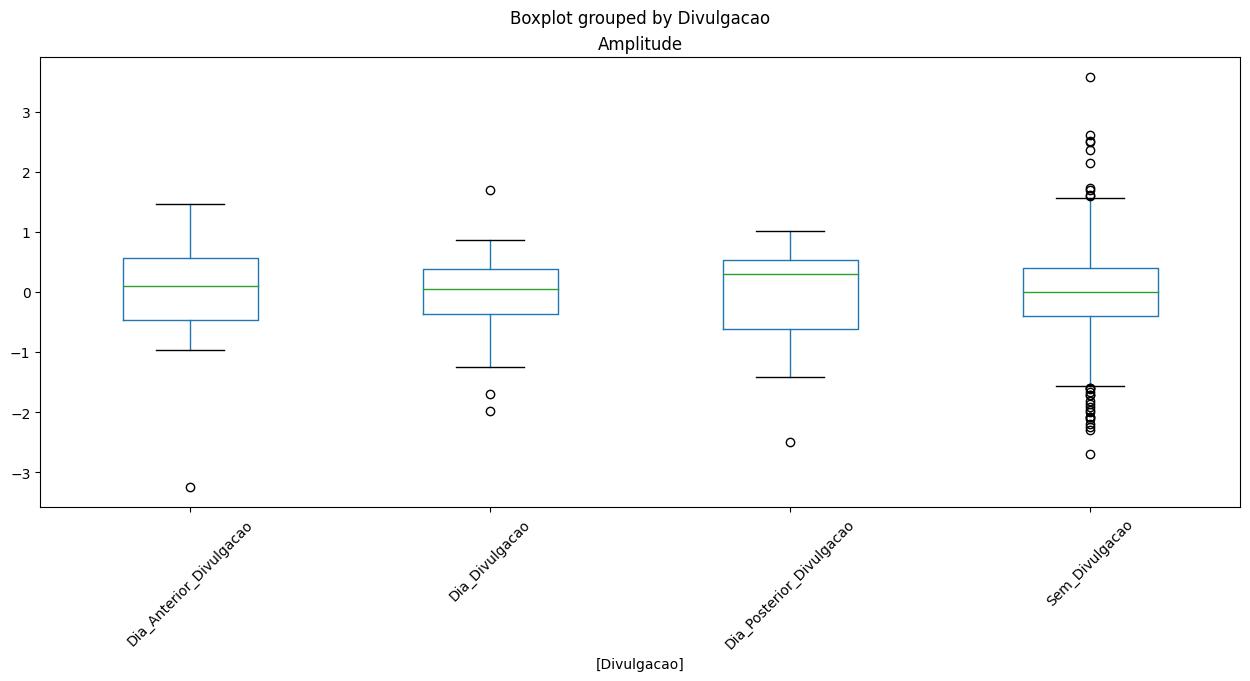

In [10]:
ax = teste_anova1.boxplot(by='Divulgacao', grid = False,figsize=(15,6))
plt.xticks(rotation=45)

In [11]:
modelo1 = ols('Amplitude ~ Divulgacao * Nome_Papel', data = teste_anova1).fit()
resultado1 = sm.stats.anova_lm(modelo1)
resultado1

df      sum_sq   mean_sq         F    PR(>F)
Divulgacao                3.0    0.291295  0.097098  0.219262  0.883069
Nome_Papel                1.0    0.678764  0.678764  1.532743  0.215885
Divulgacao:Nome_Papel     3.0    0.661369  0.220456  0.497821  0.683834
Residual               1580.0  699.691147  0.442842       NaN       NaN

O Pvalor ficou acima do nível de significância em todos os testes, o que indica que não existe evidência estatística suficiente para rejeição de H0



## Teste 2

 ### Hipóteses

  H0 = Não existe diferença de variação da amplitude das ações em relação ao dia até a divulgação

  H1 = Existem diferenças de variação da amplitude das ações em relação ao dia até a divulgação

In [12]:
teste_anova2 = df[['Amplitude','Ate_Divulgacao','Nome_Papel']]
teste_anova2.loc[teste_anova2['Ate_Divulgacao'] < 0, 'Ate_Divulgacao'] = pd.NA
teste_anova2 = teste_anova2.dropna(subset=['Ate_Divulgacao'])


modelo2 = ols('Amplitude ~ Ate_Divulgacao * Nome_Papel', data = teste_anova2).fit()
resultado2 = sm.stats.anova_lm(modelo2)
resultado2

df      sum_sq   mean_sq         F    PR(>F)
Nome_Papel                    1.0    0.678568  0.678568  1.535183  0.215520
Ate_Divulgacao                1.0    0.435641  0.435641  0.985588  0.320975
Ate_Divulgacao:Nome_Papel     1.0    0.062554  0.062554  0.141521  0.706824
Residual                   1584.0  700.145812  0.442011       NaN       NaN

Da mesma maneira que o teste anterior o Pvalor ficou alto, apontando que não existe evidência estatística o suficiente para rejeitar H0

## Teste 3 - Realizando um teste para cara papel

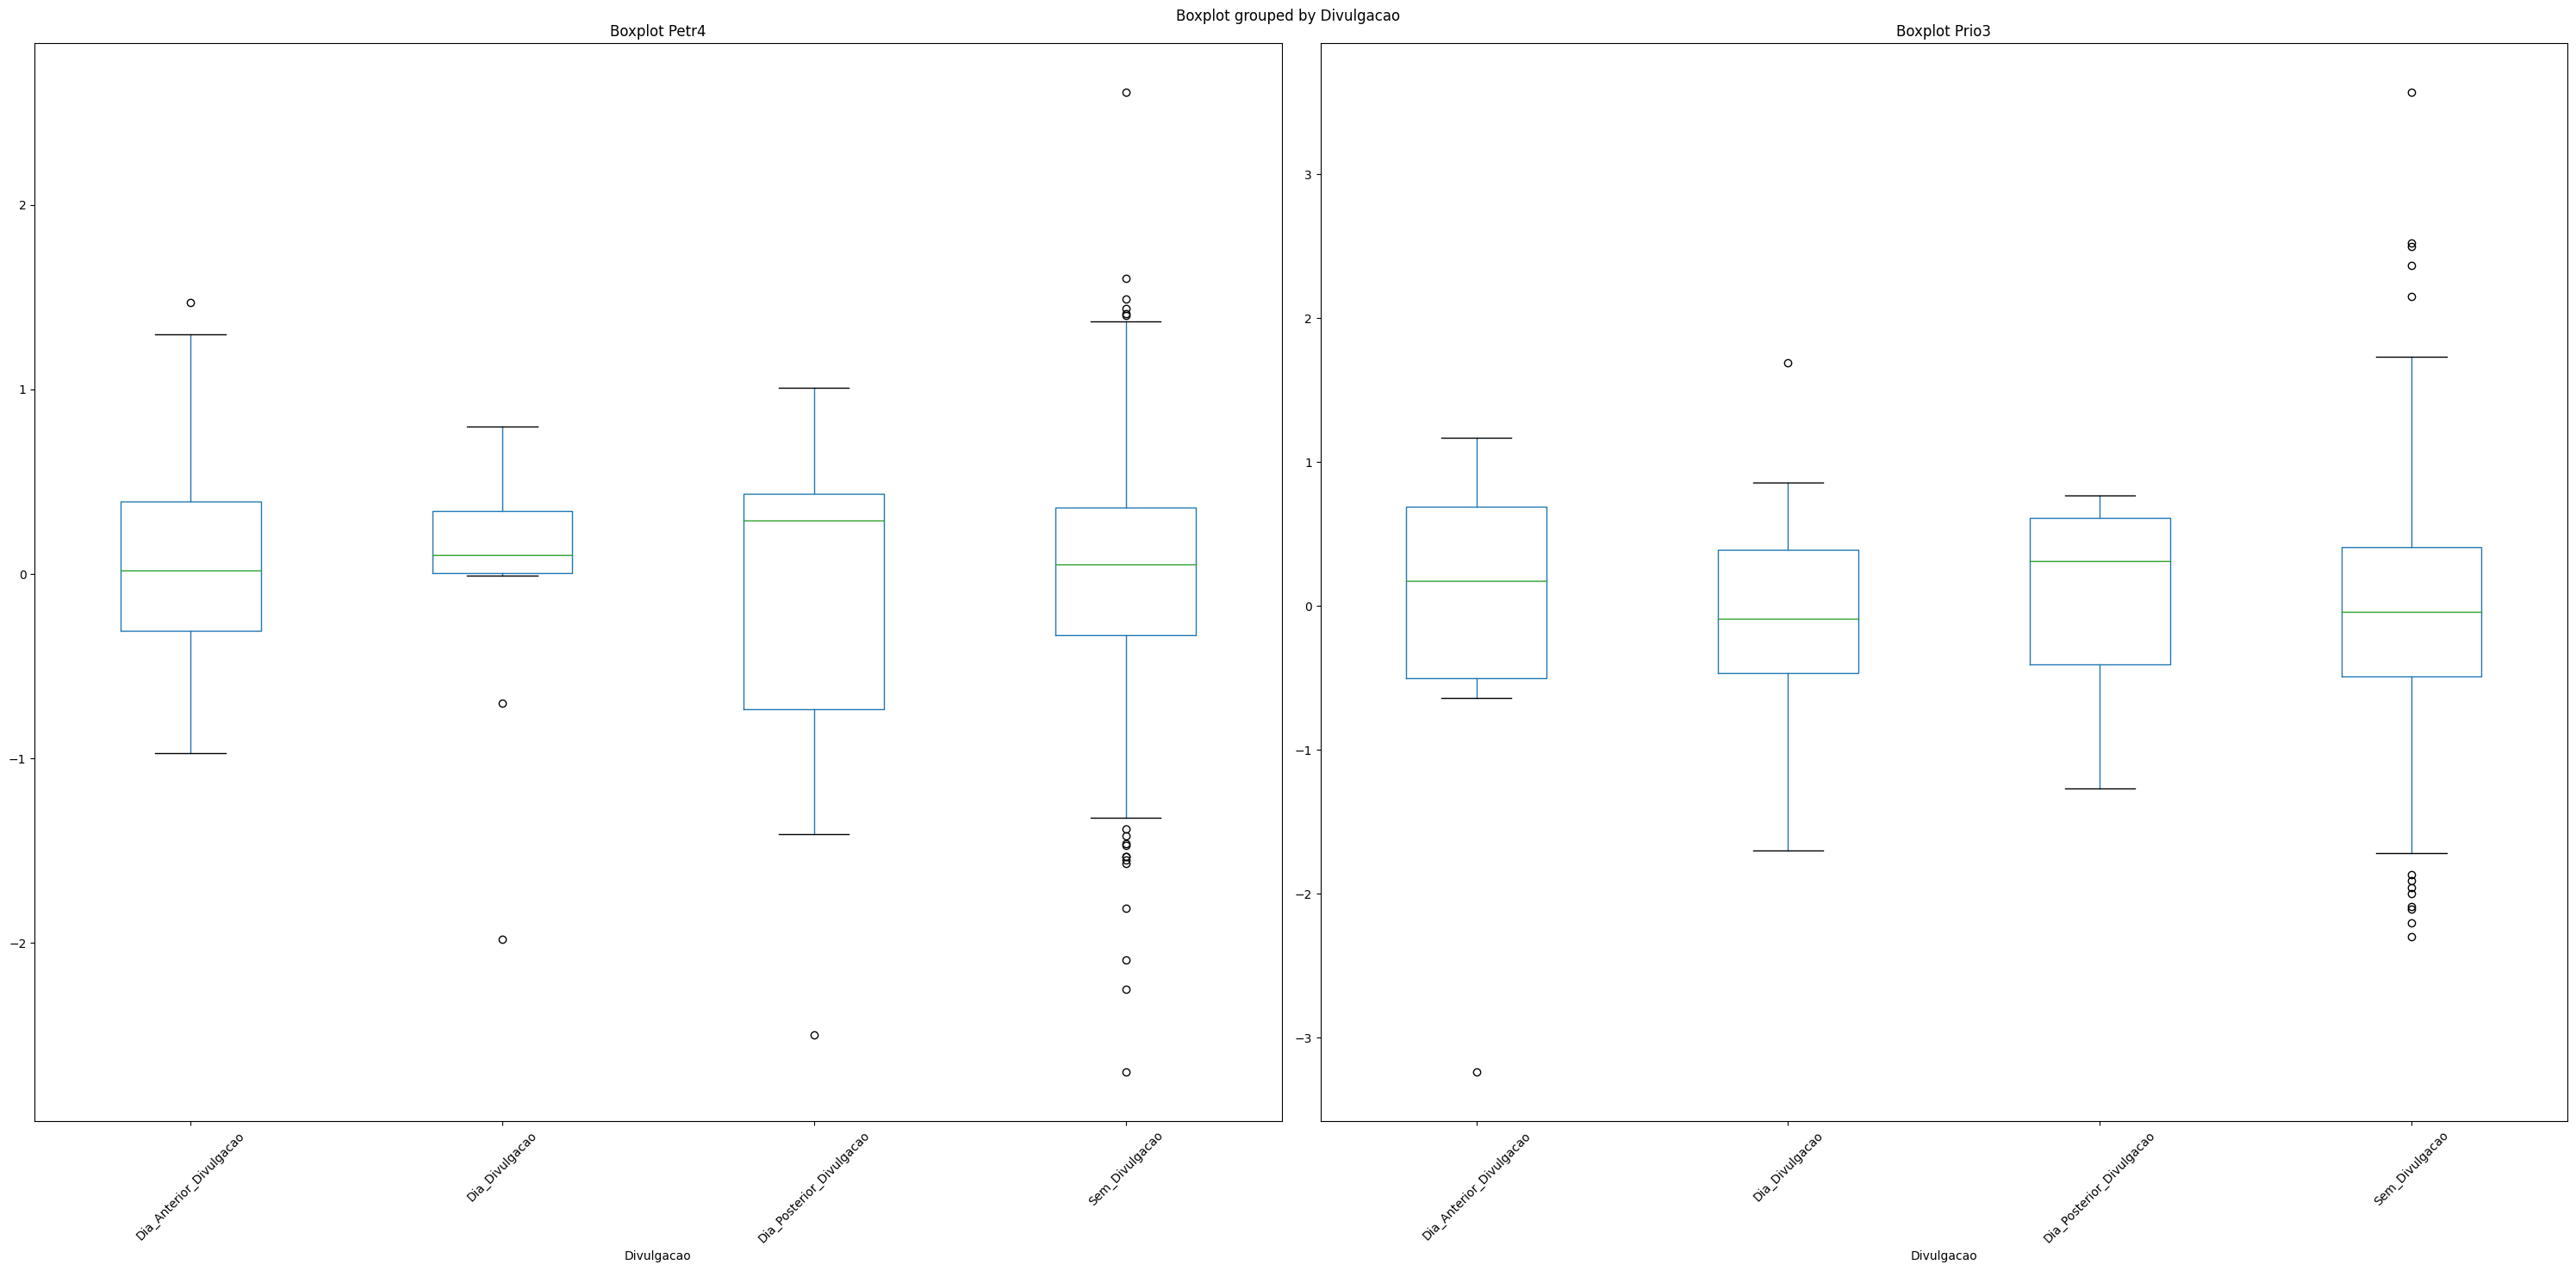

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
Petr4.boxplot(by='Divulgacao',column='Amplitude', grid=False, ax=ax1)
ax1.set_title('Boxplot Petr4')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
Prio3.boxplot(by='Divulgacao',column='Amplitude', grid=False, ax=ax2)
ax2.set_title('Boxplot Prio3')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Petr4

modelo3_petr4 = ols('Amplitude ~ Divulgacao', data = Petr4).fit()
resultado_petra = sm.stats.anova_lm(modelo3_petr4)
resultado_petra



df      sum_sq   mean_sq         F    PR(>F)
Divulgacao    3.0    0.875268  0.291756  0.841417  0.471362
Residual    788.0  273.234079  0.346744       NaN       NaN

In [15]:
# Prio3

modelo3_prio3 = ols('Amplitude ~ Divulgacao', data = Prio3).fit()
resultado_prio = sm.stats.anova_lm(modelo3_prio3)
resultado_prio

df      sum_sq   mean_sq         F    PR(>F)
Divulgacao    3.0    0.077592  0.025864  0.048034  0.986054
Residual    792.0  426.457069  0.538456       NaN       NaN

# Series Temporais

Ao realizar o ANOVA não foi possível encontrar envidência estatística de que existe diferenças nos dias de divulgação do balanço. Porém via análise gráfica (blox-plot) foi possível notar que em dias que não tem divulgação existe uma variabilidade maior na amplitude dos preços das ações. Por isso será trabalhado um modelo de série temporal para que seja possível prever essa variação em relação ao tempo.

In [16]:
df.set_index('Date', drop= True, inplace=True)
Brent.set_index('Date', drop=True, inplace=True)
WTI.set_index('Date', drop=True, inplace=True)

In [17]:
petr4 = df[df['Nome_Papel'] == 'Petr4']
prio3 = df[df['Nome_Papel'] == 'Prio3']
divulgacoes_petr4 = df[(df['Divulgacao'] != 'Sem_Divulgacao') & (df['Nome_Papel'] != 'Petr4')]
divulgacoes_prio3 = df[(df['Divulgacao'] != 'Sem_Divulgacao') & (df['Nome_Papel'] != 'Prio3')]

## Amplitude

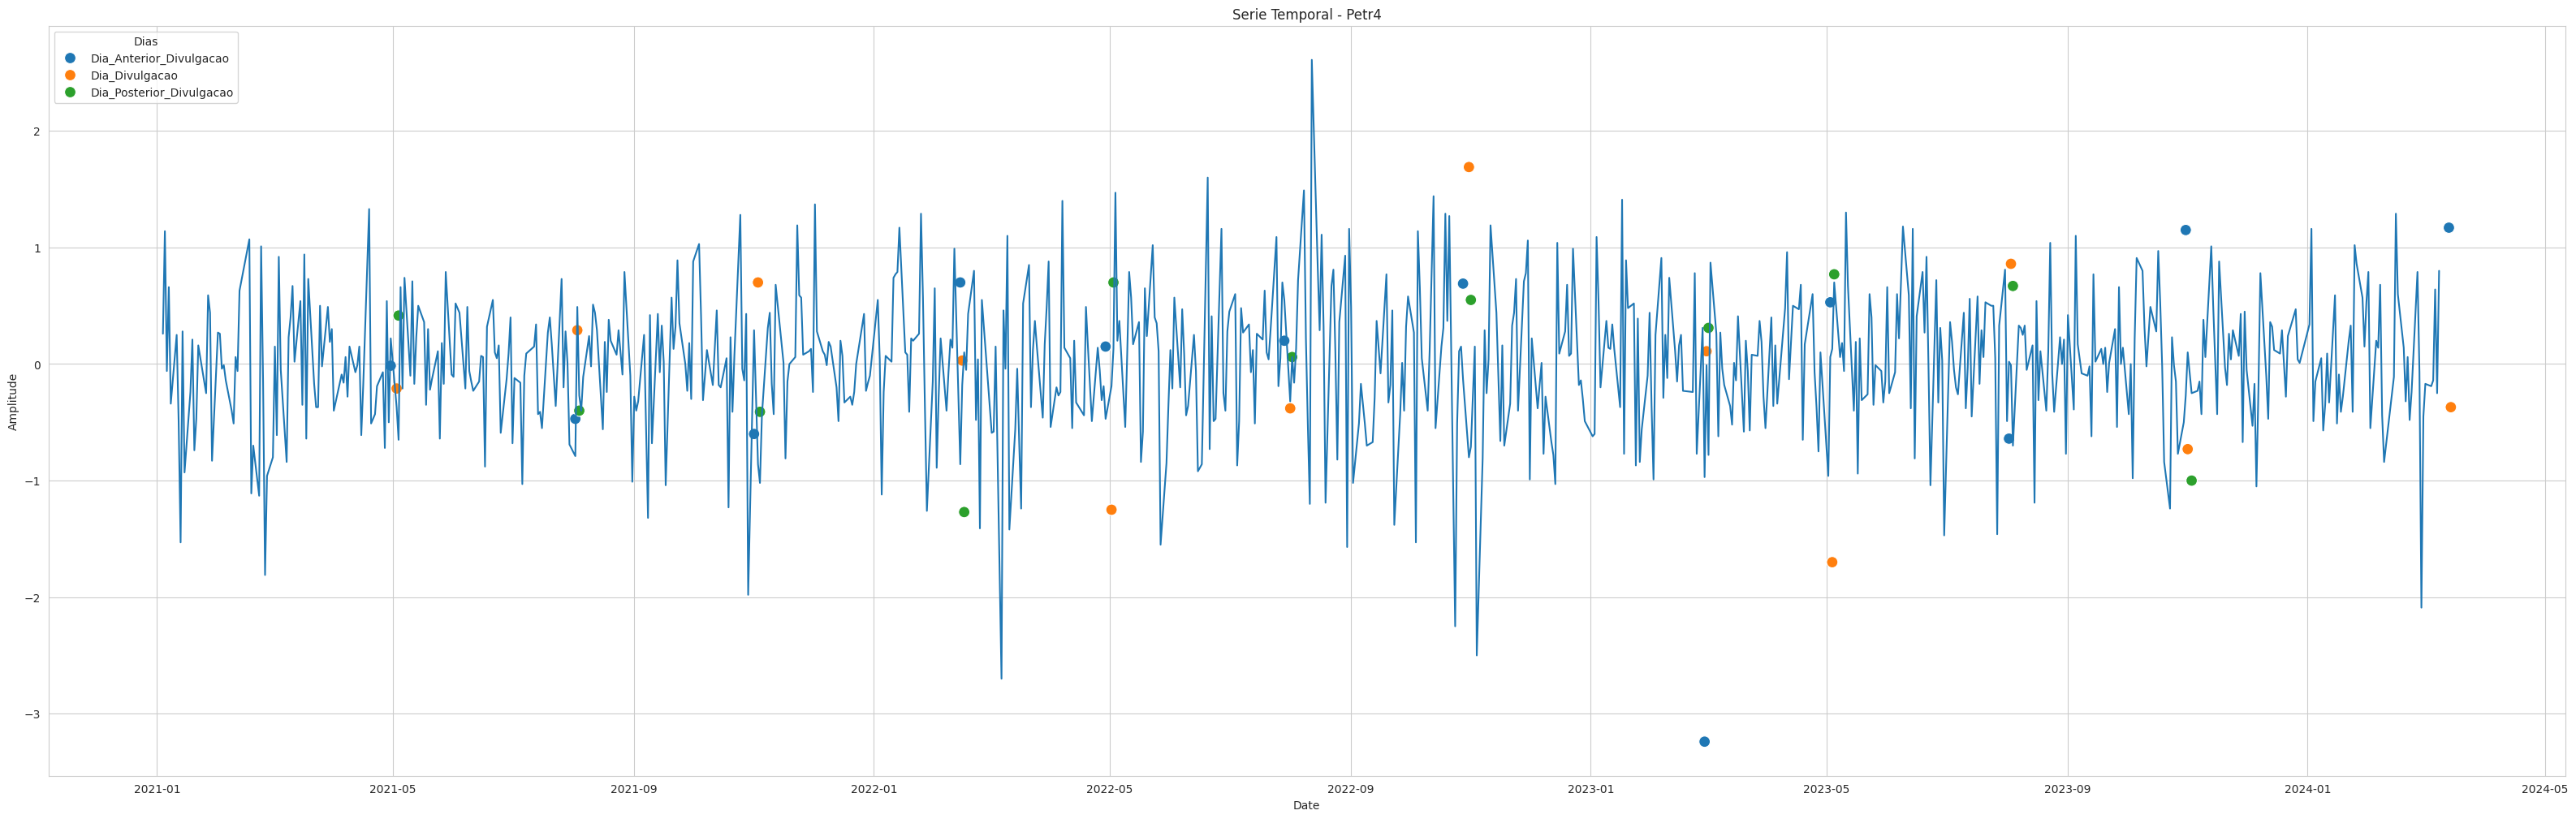

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Amplitude', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Amplitude', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

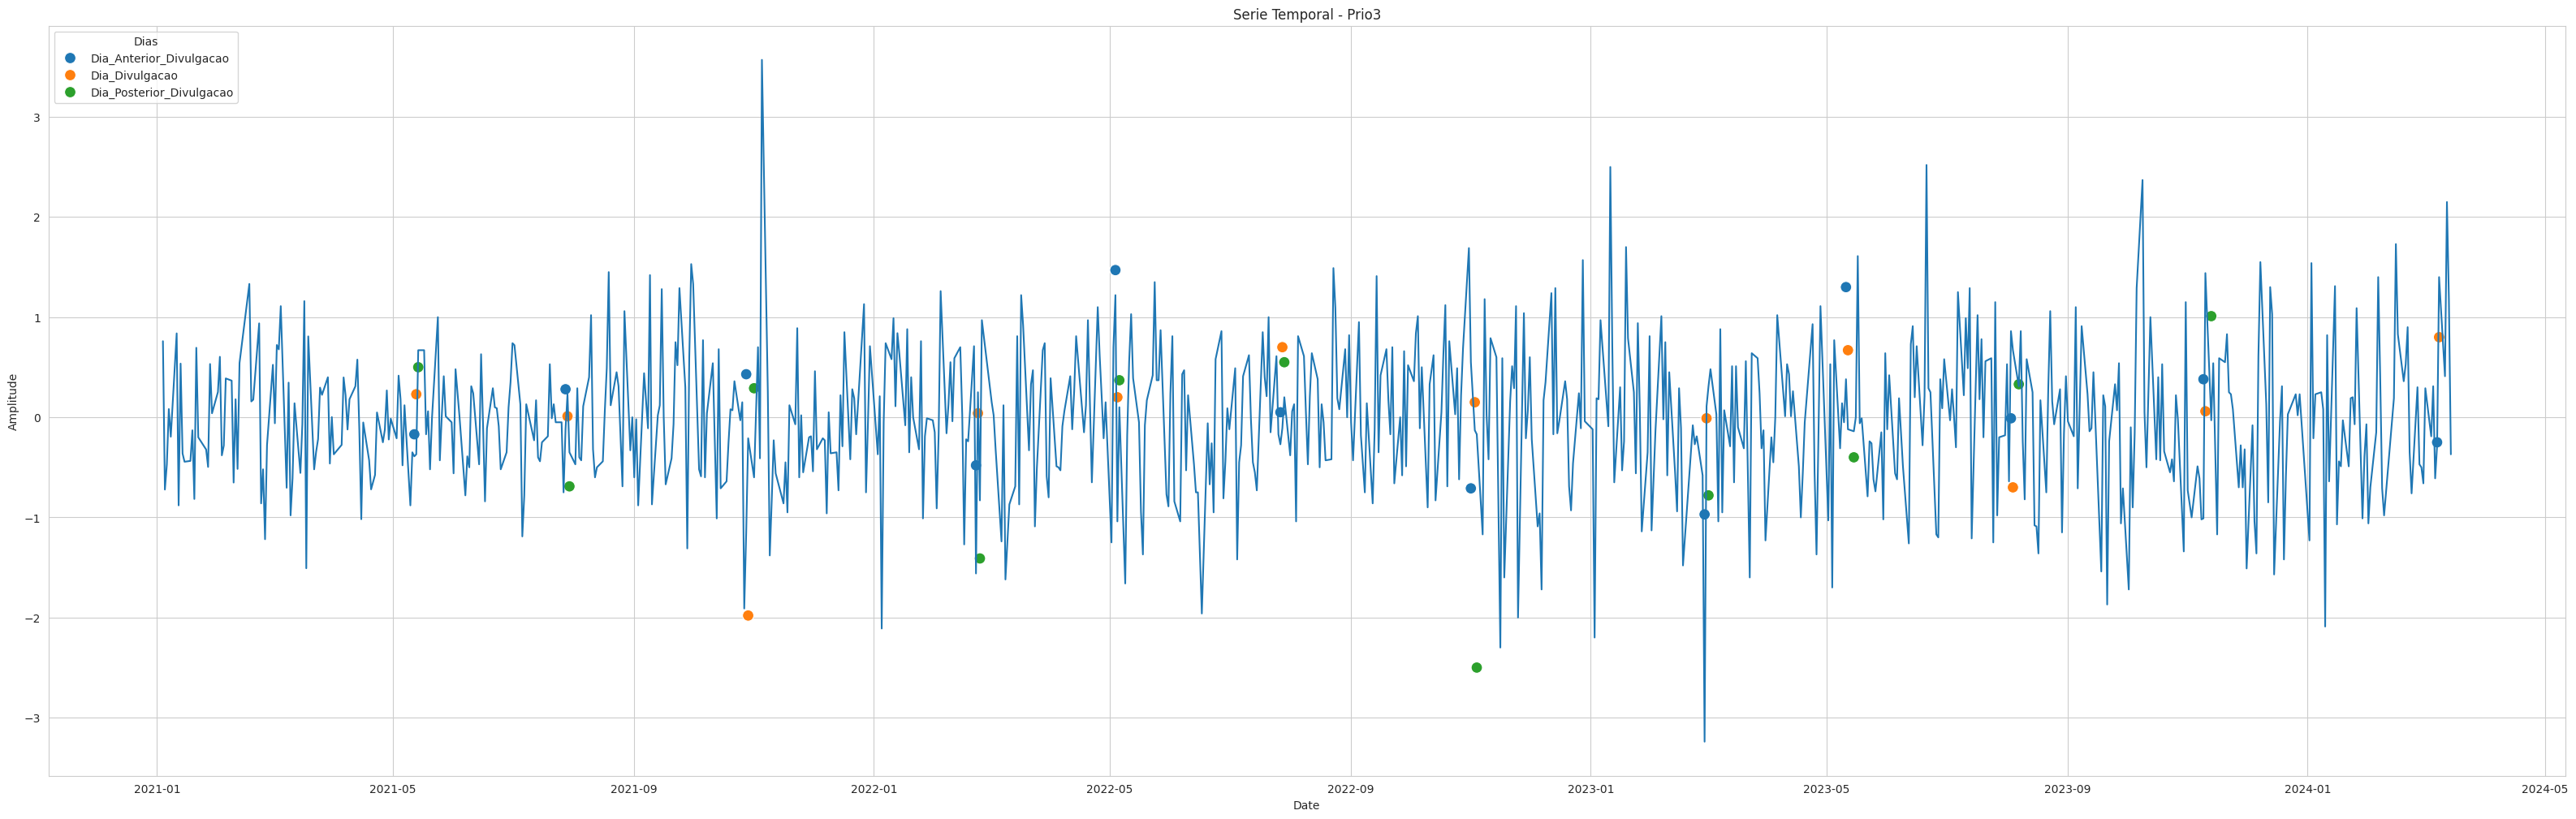

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Amplitude', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Amplitude', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

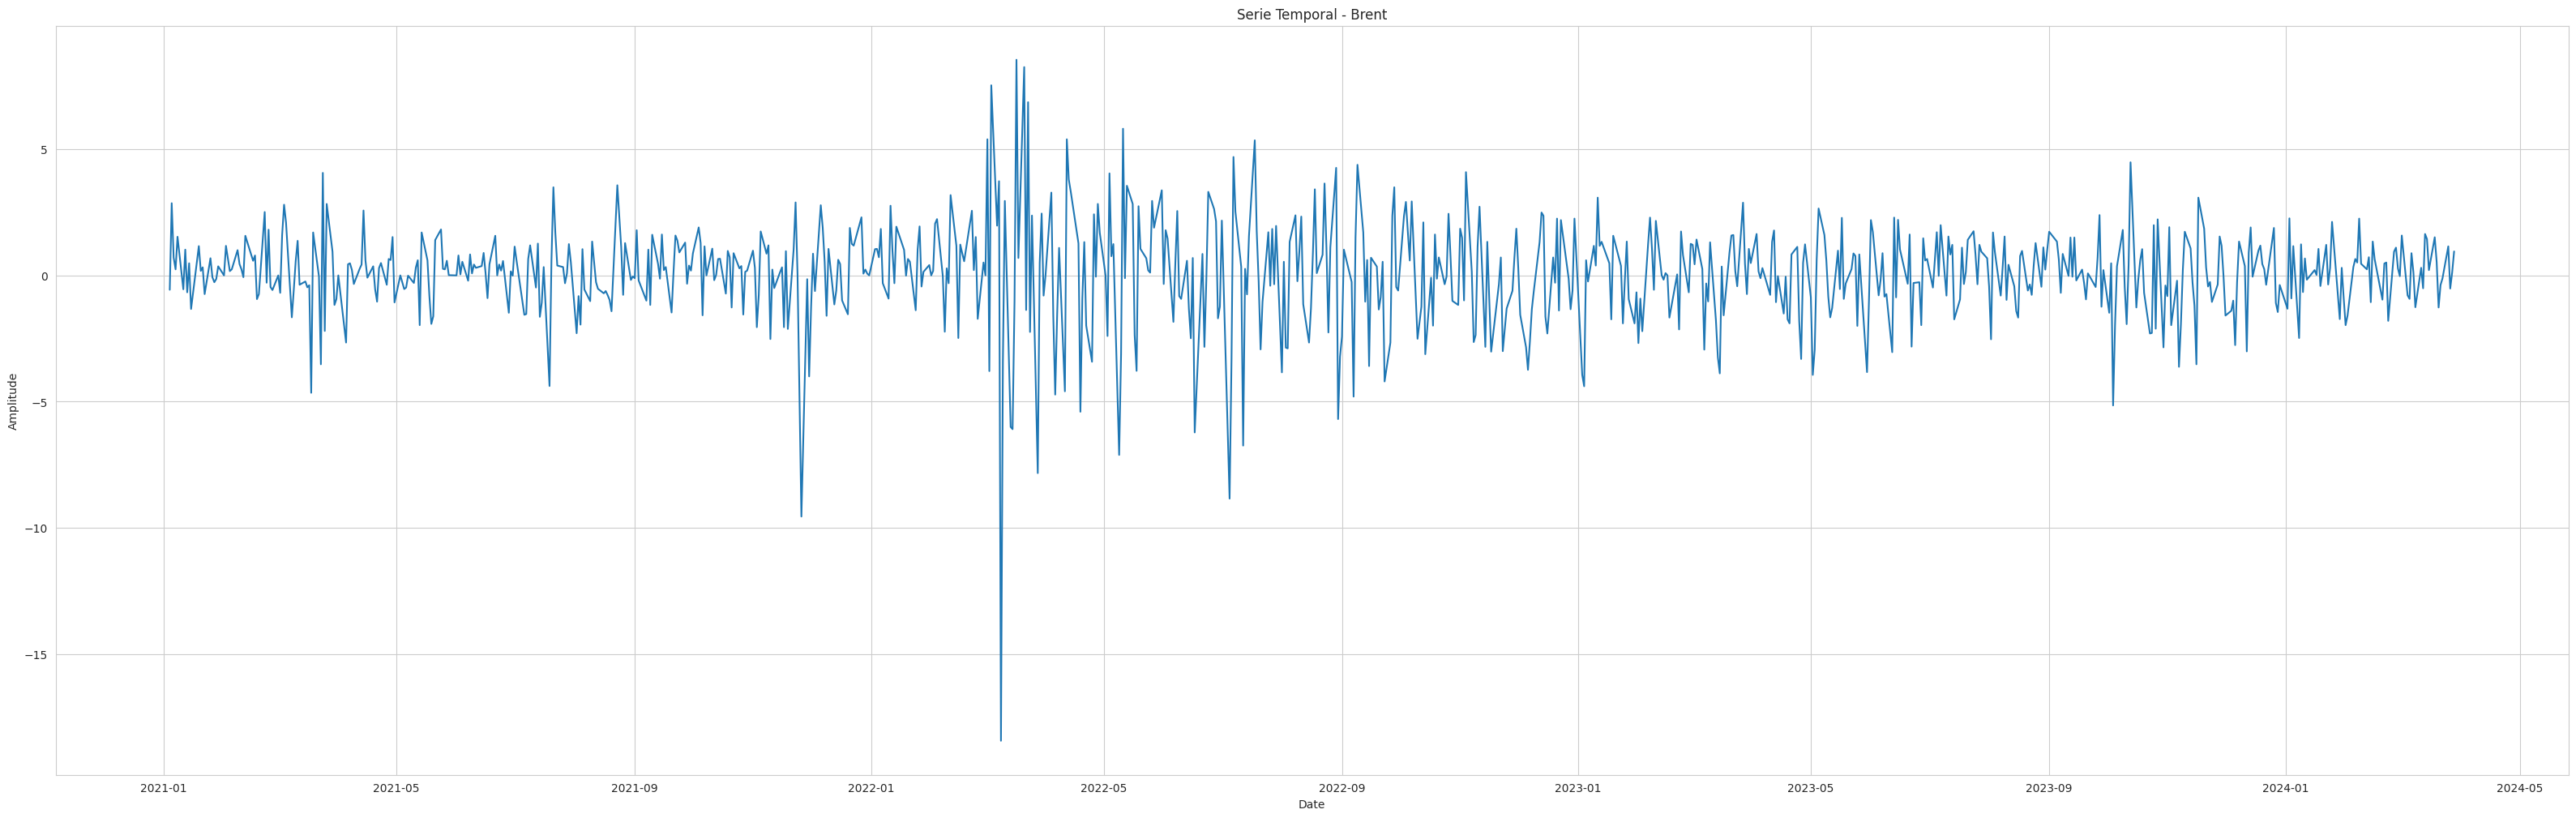

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Amplitude', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

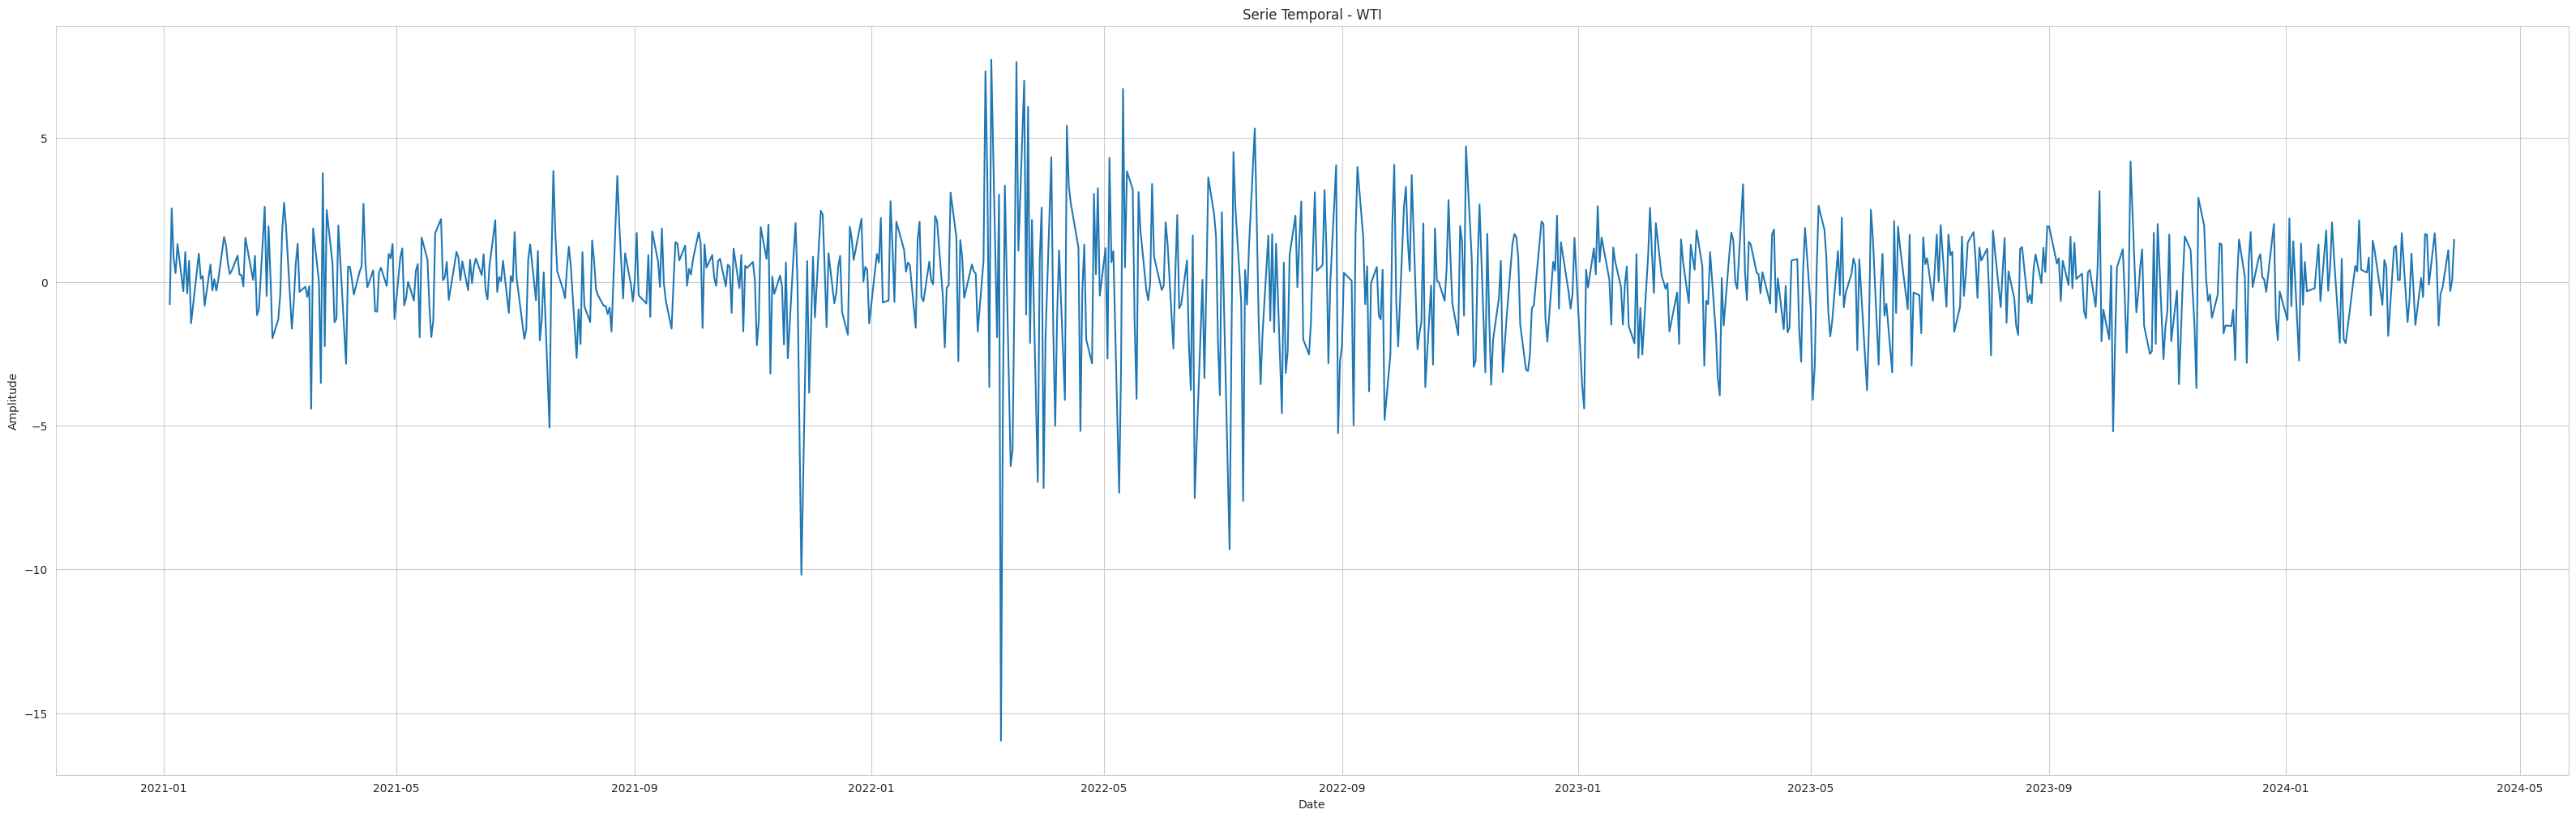

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Amplitude', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

## Variancia

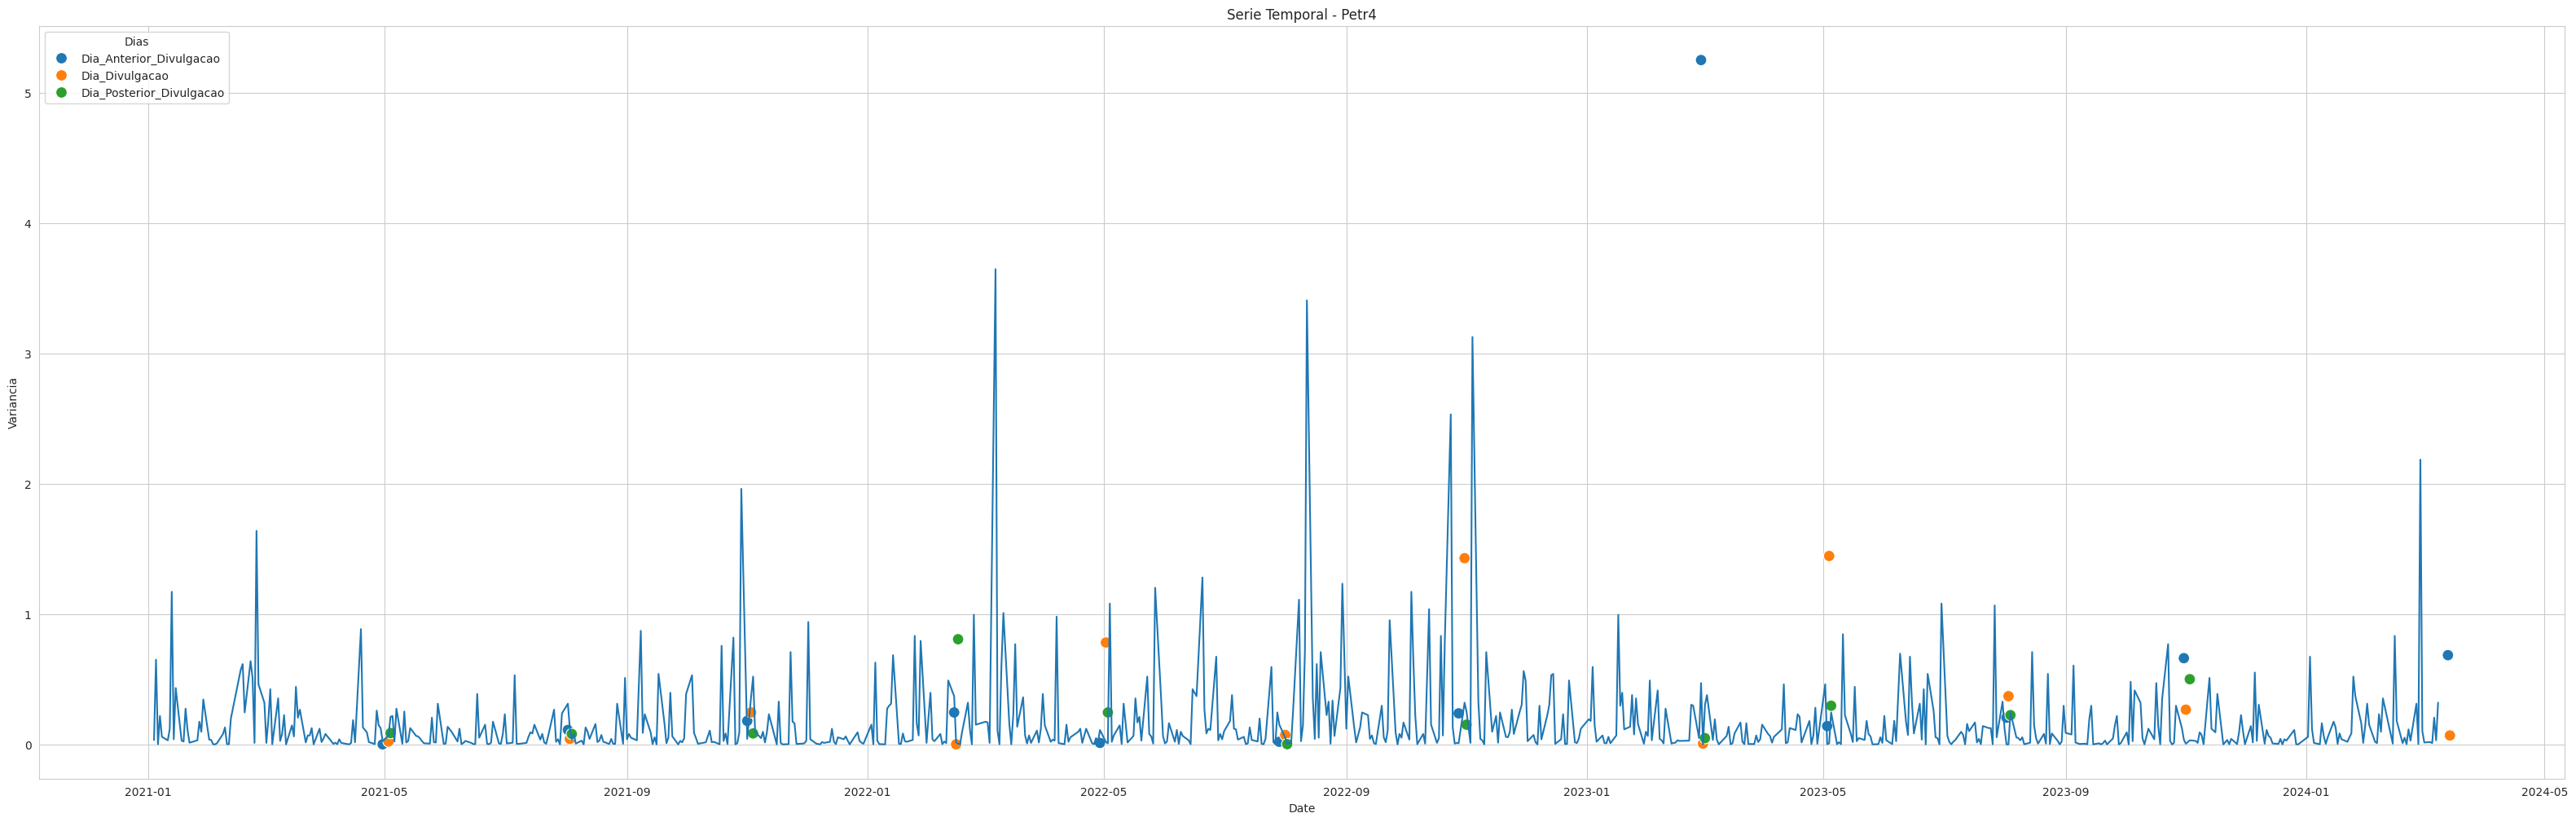

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Variancia', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Variancia', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

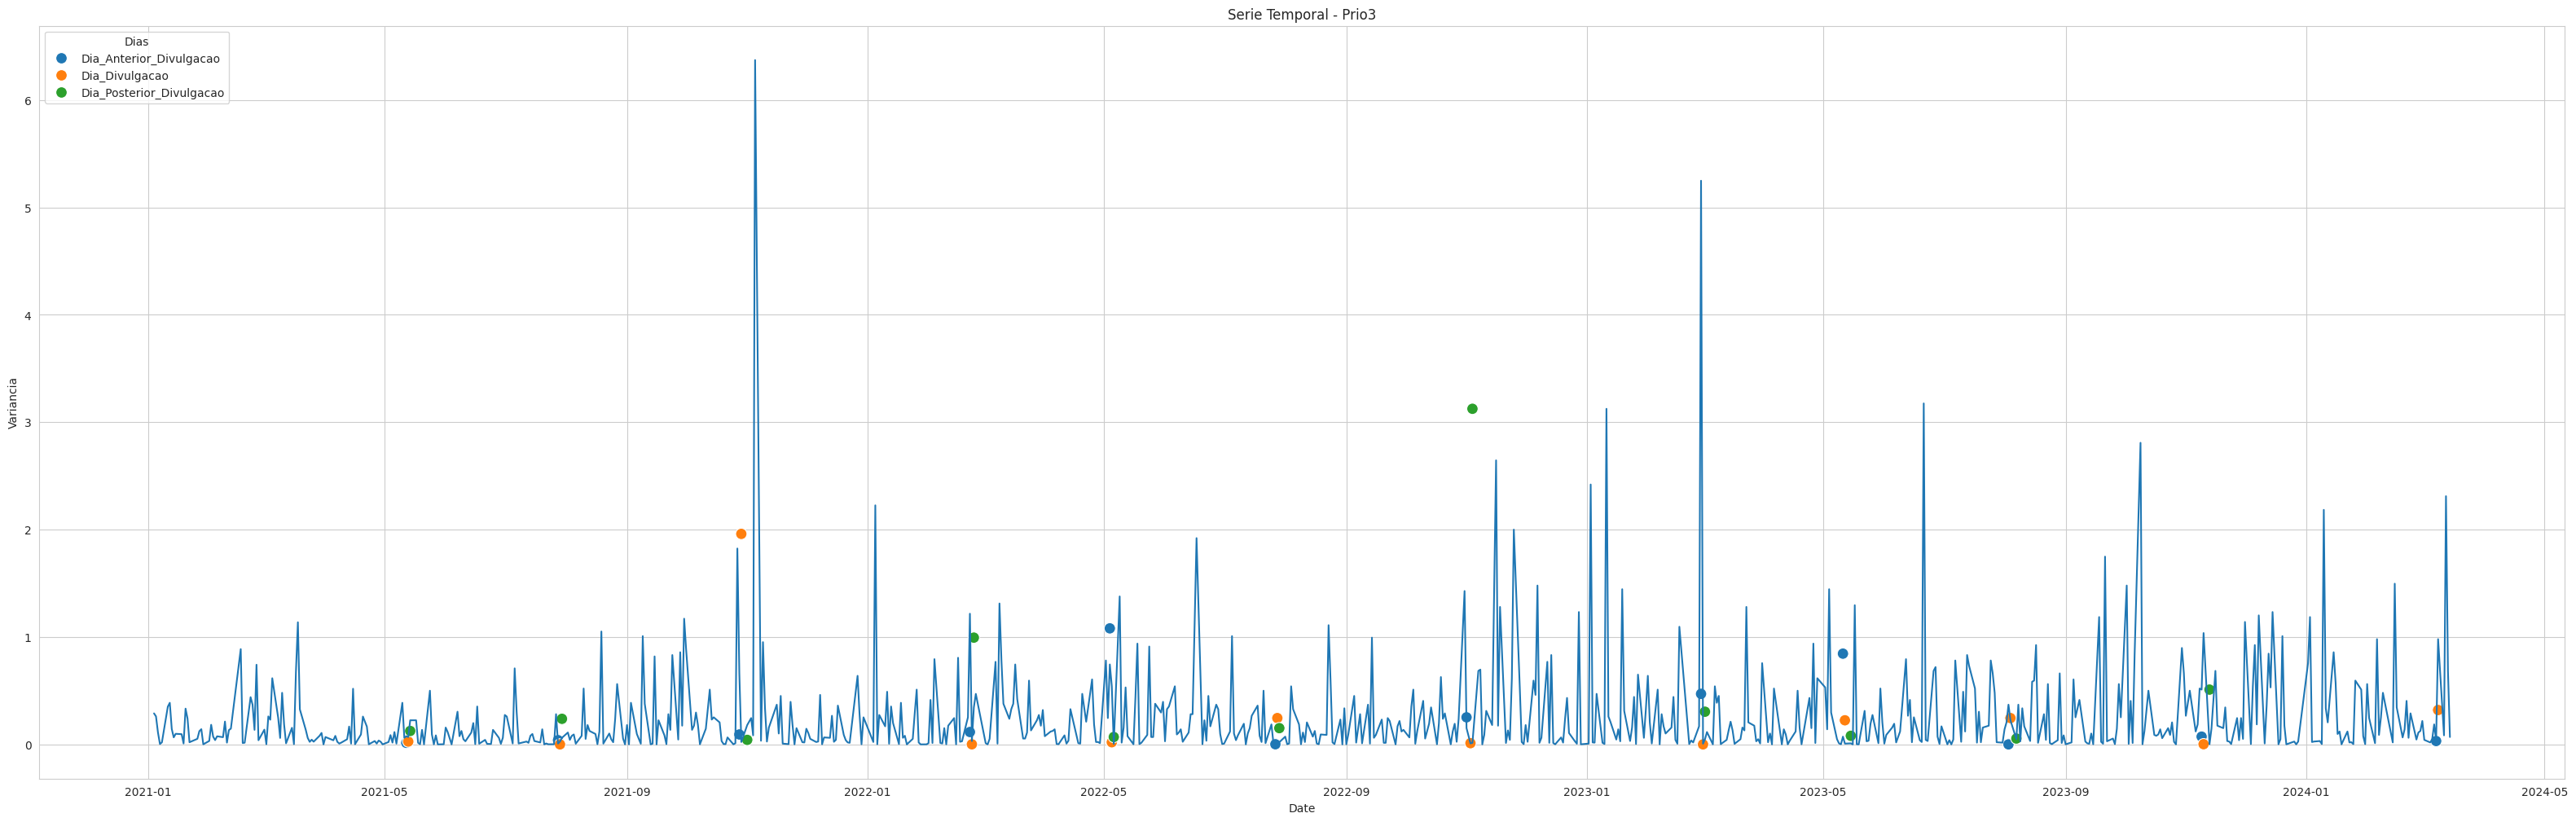

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Variancia', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Variancia', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

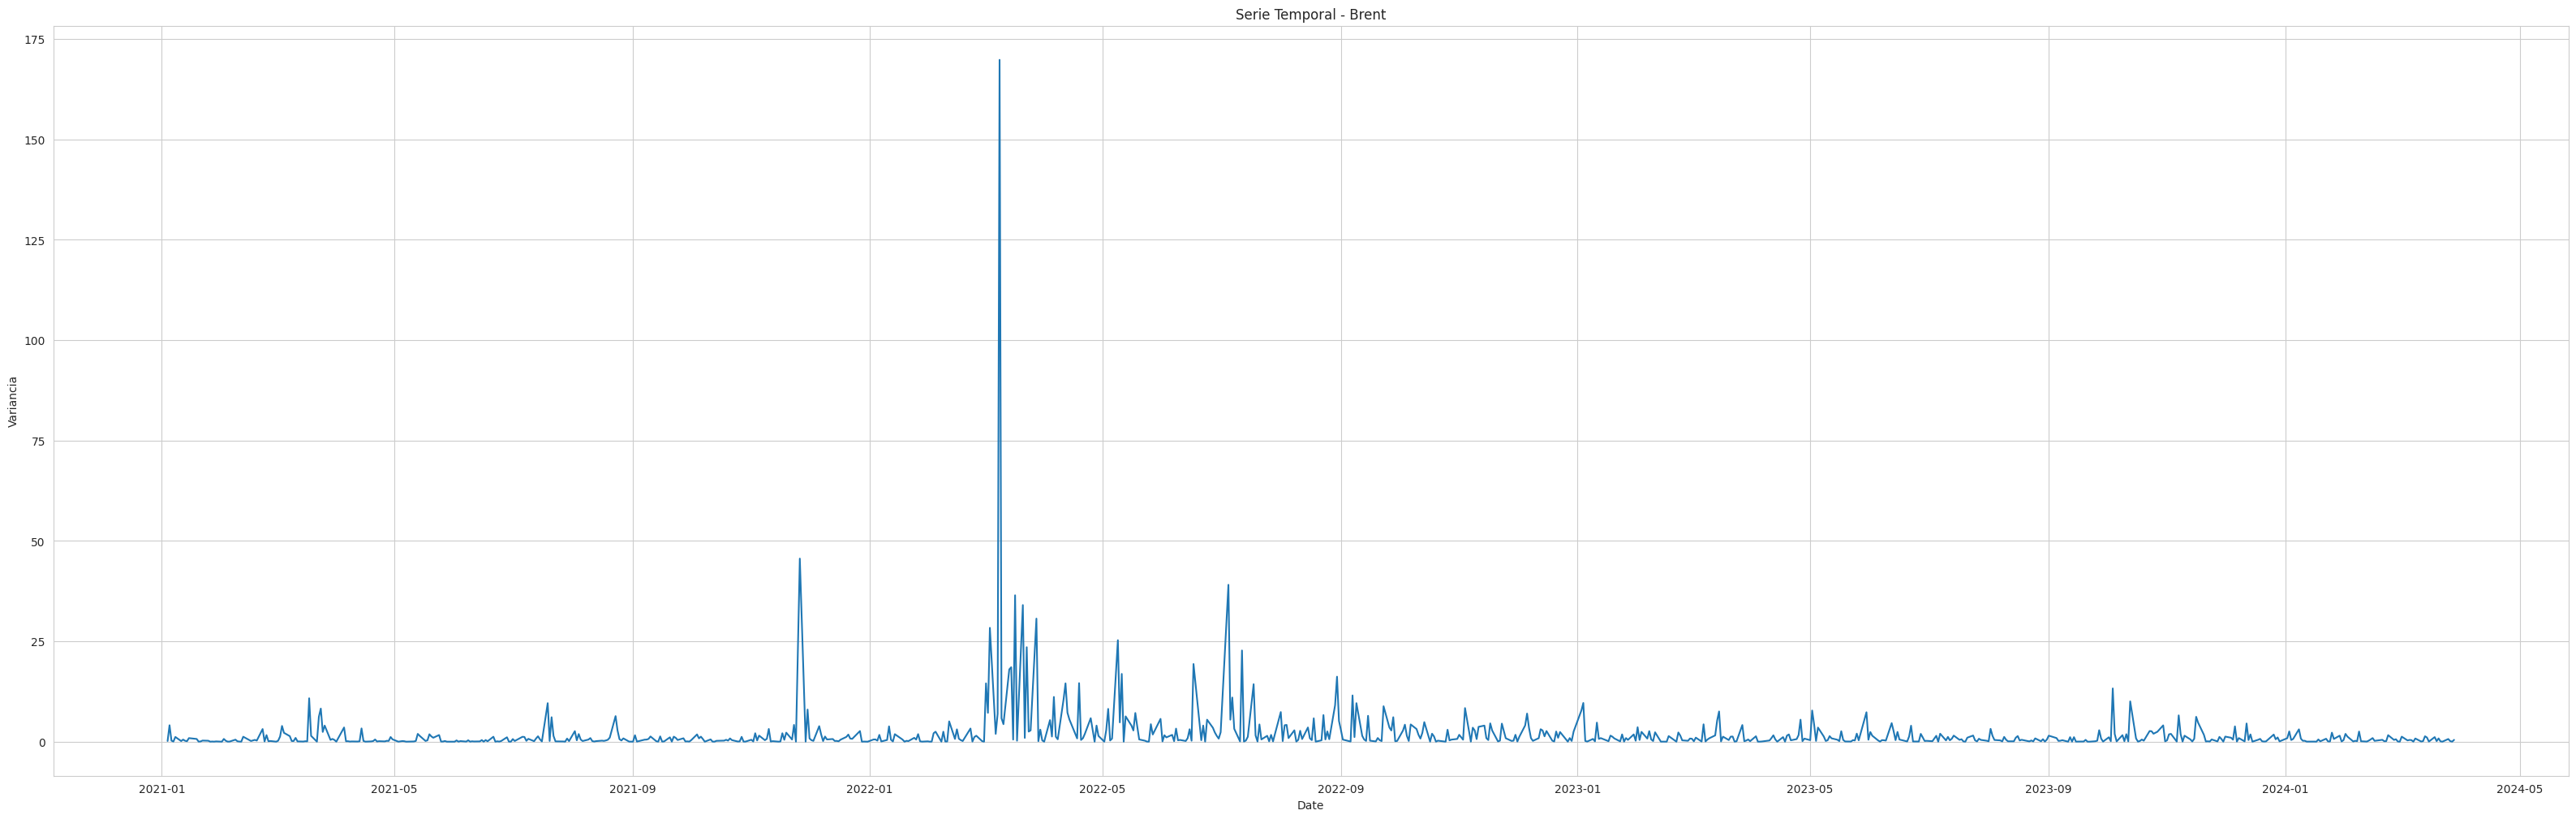

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Variancia', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

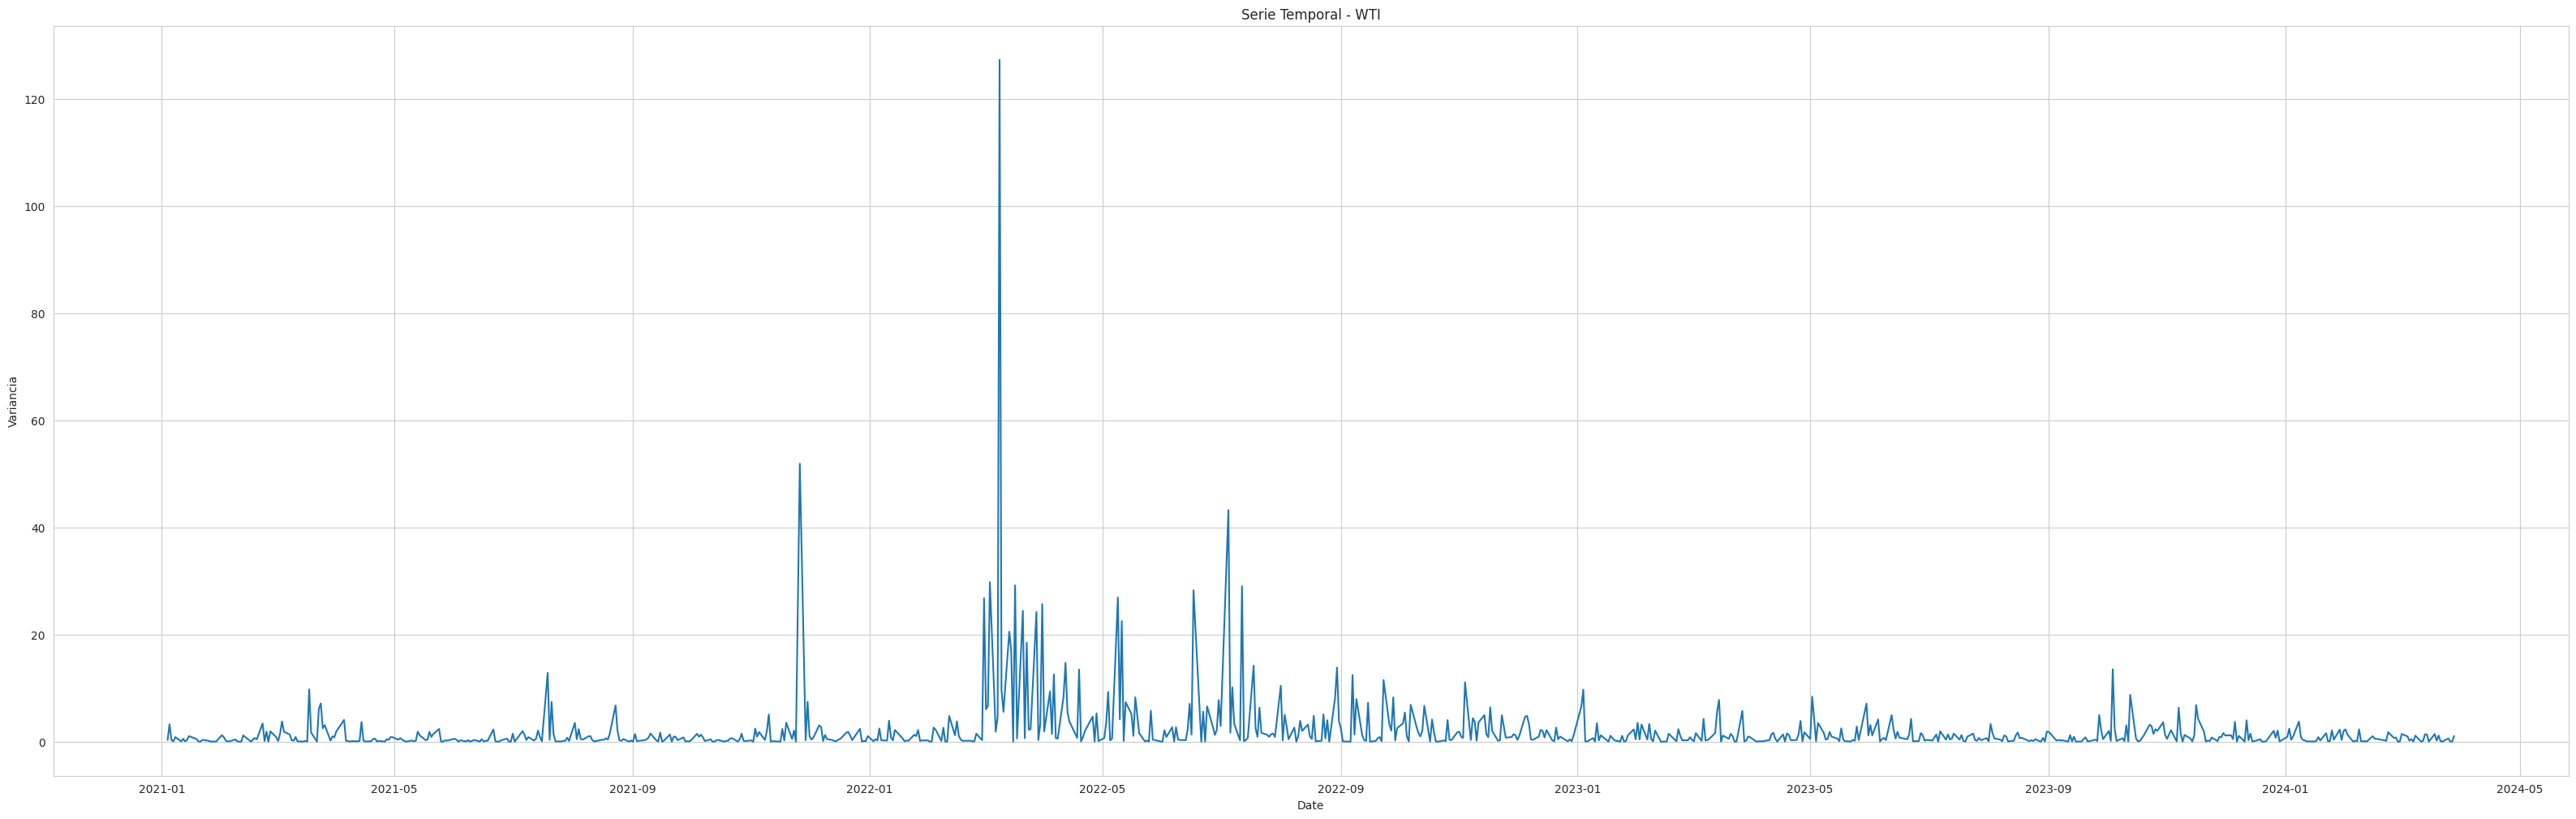

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Variancia', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

## Retorno

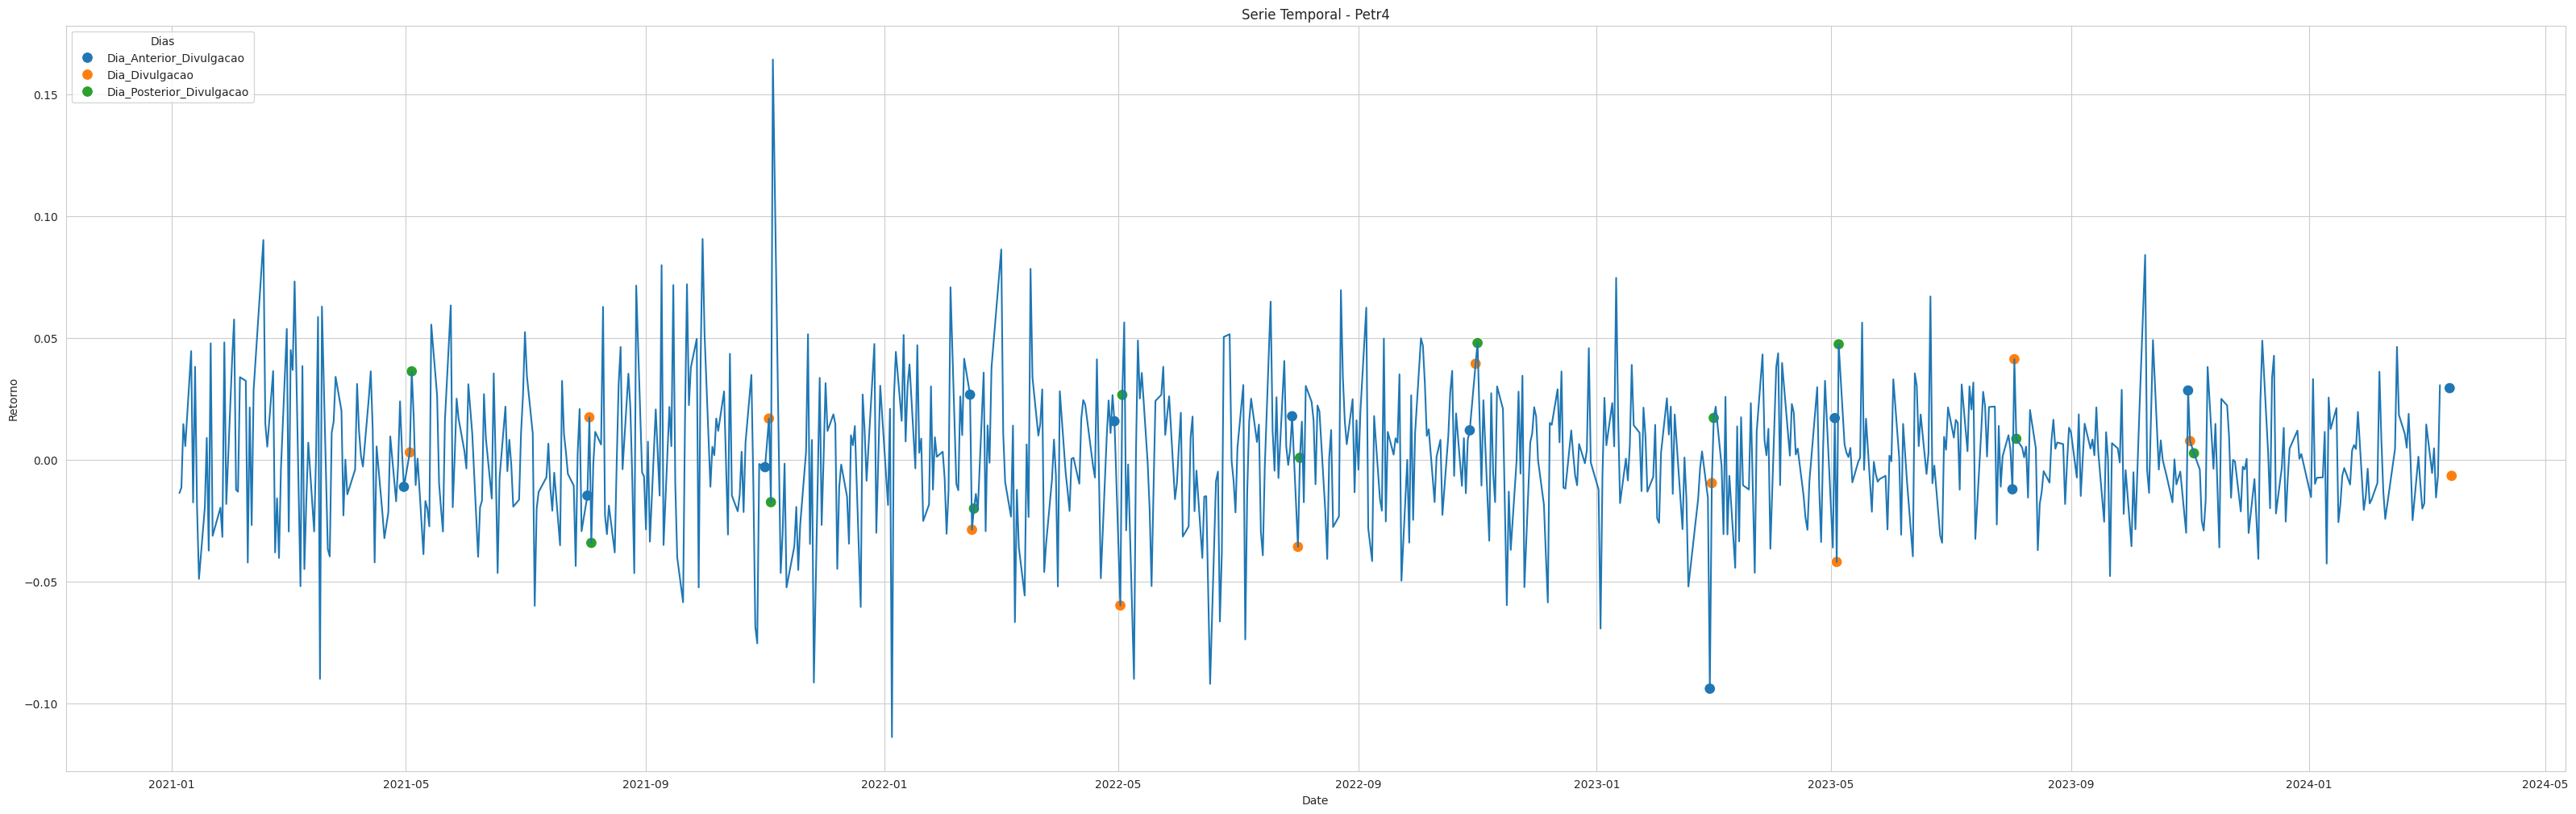

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Retorno', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Retorno', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

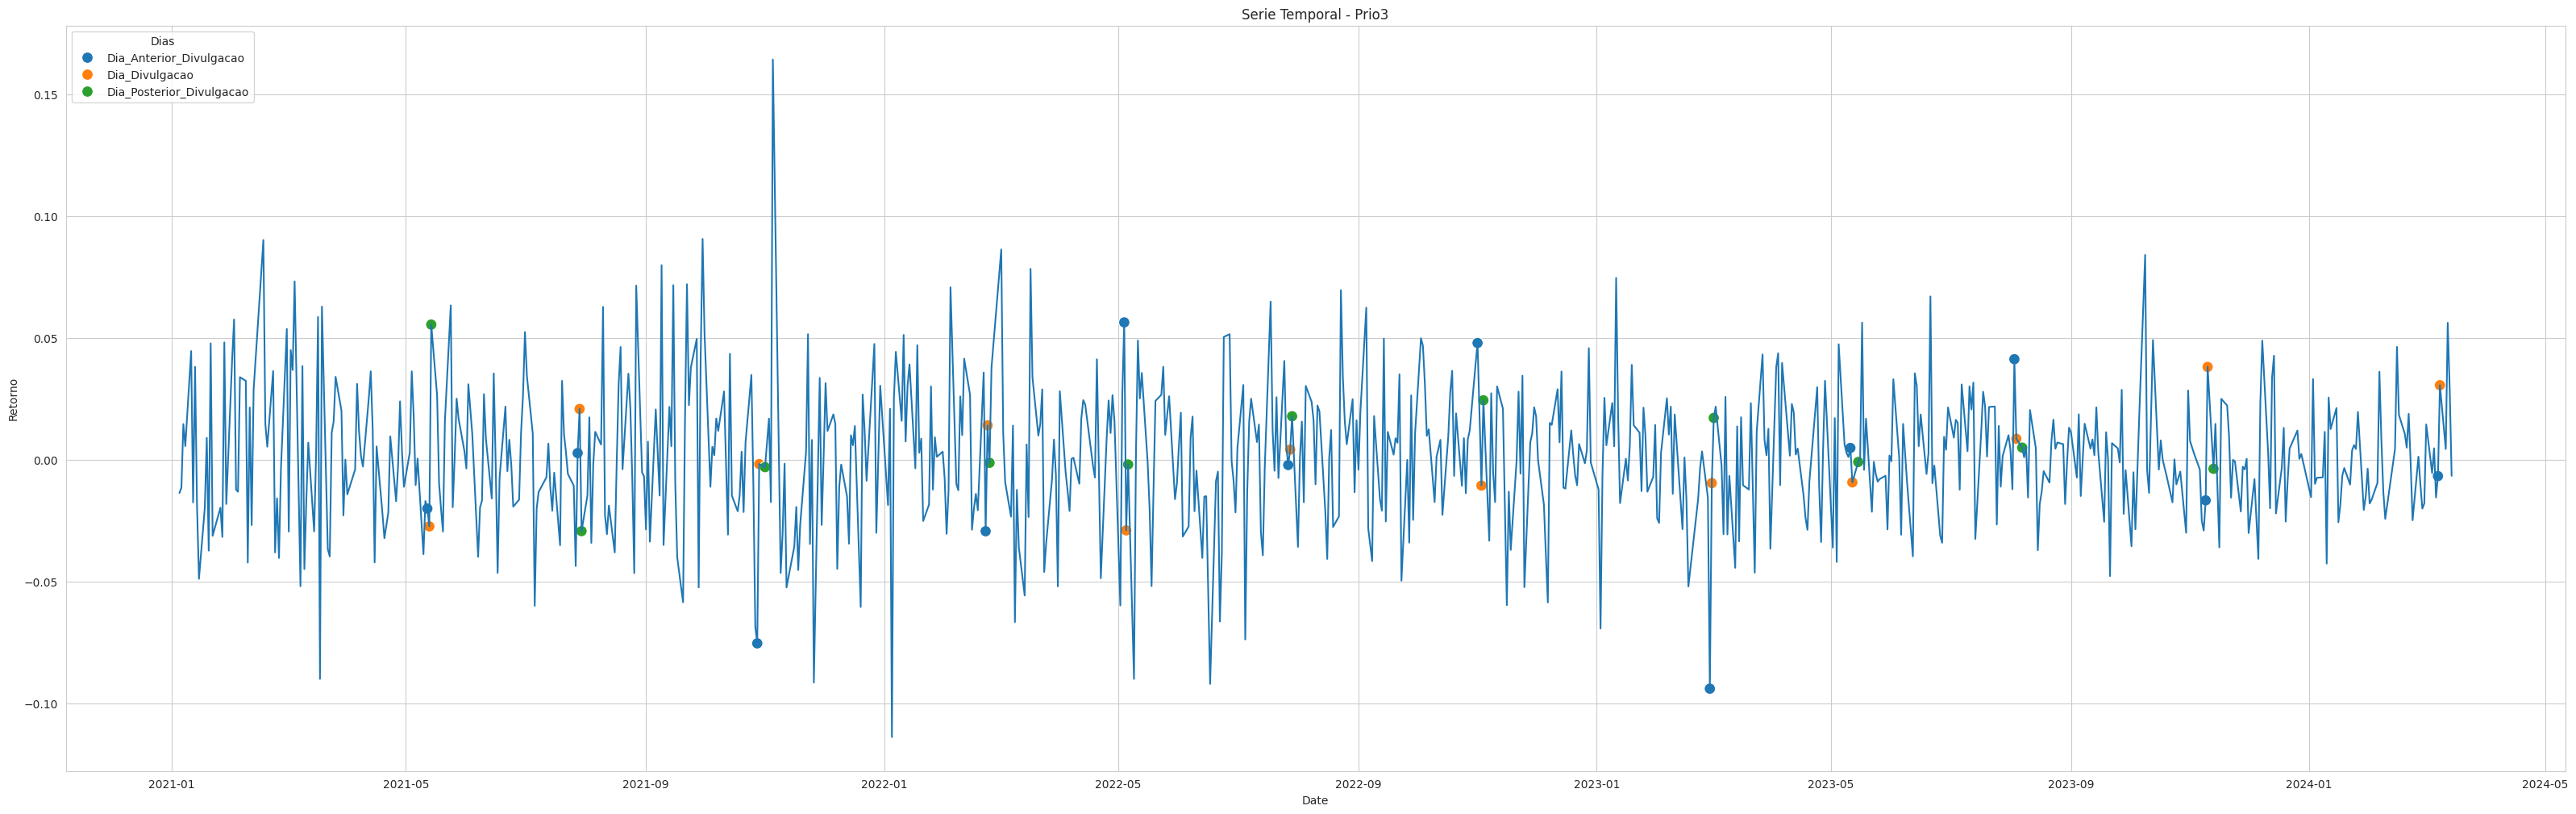

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Retorno', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Retorno', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

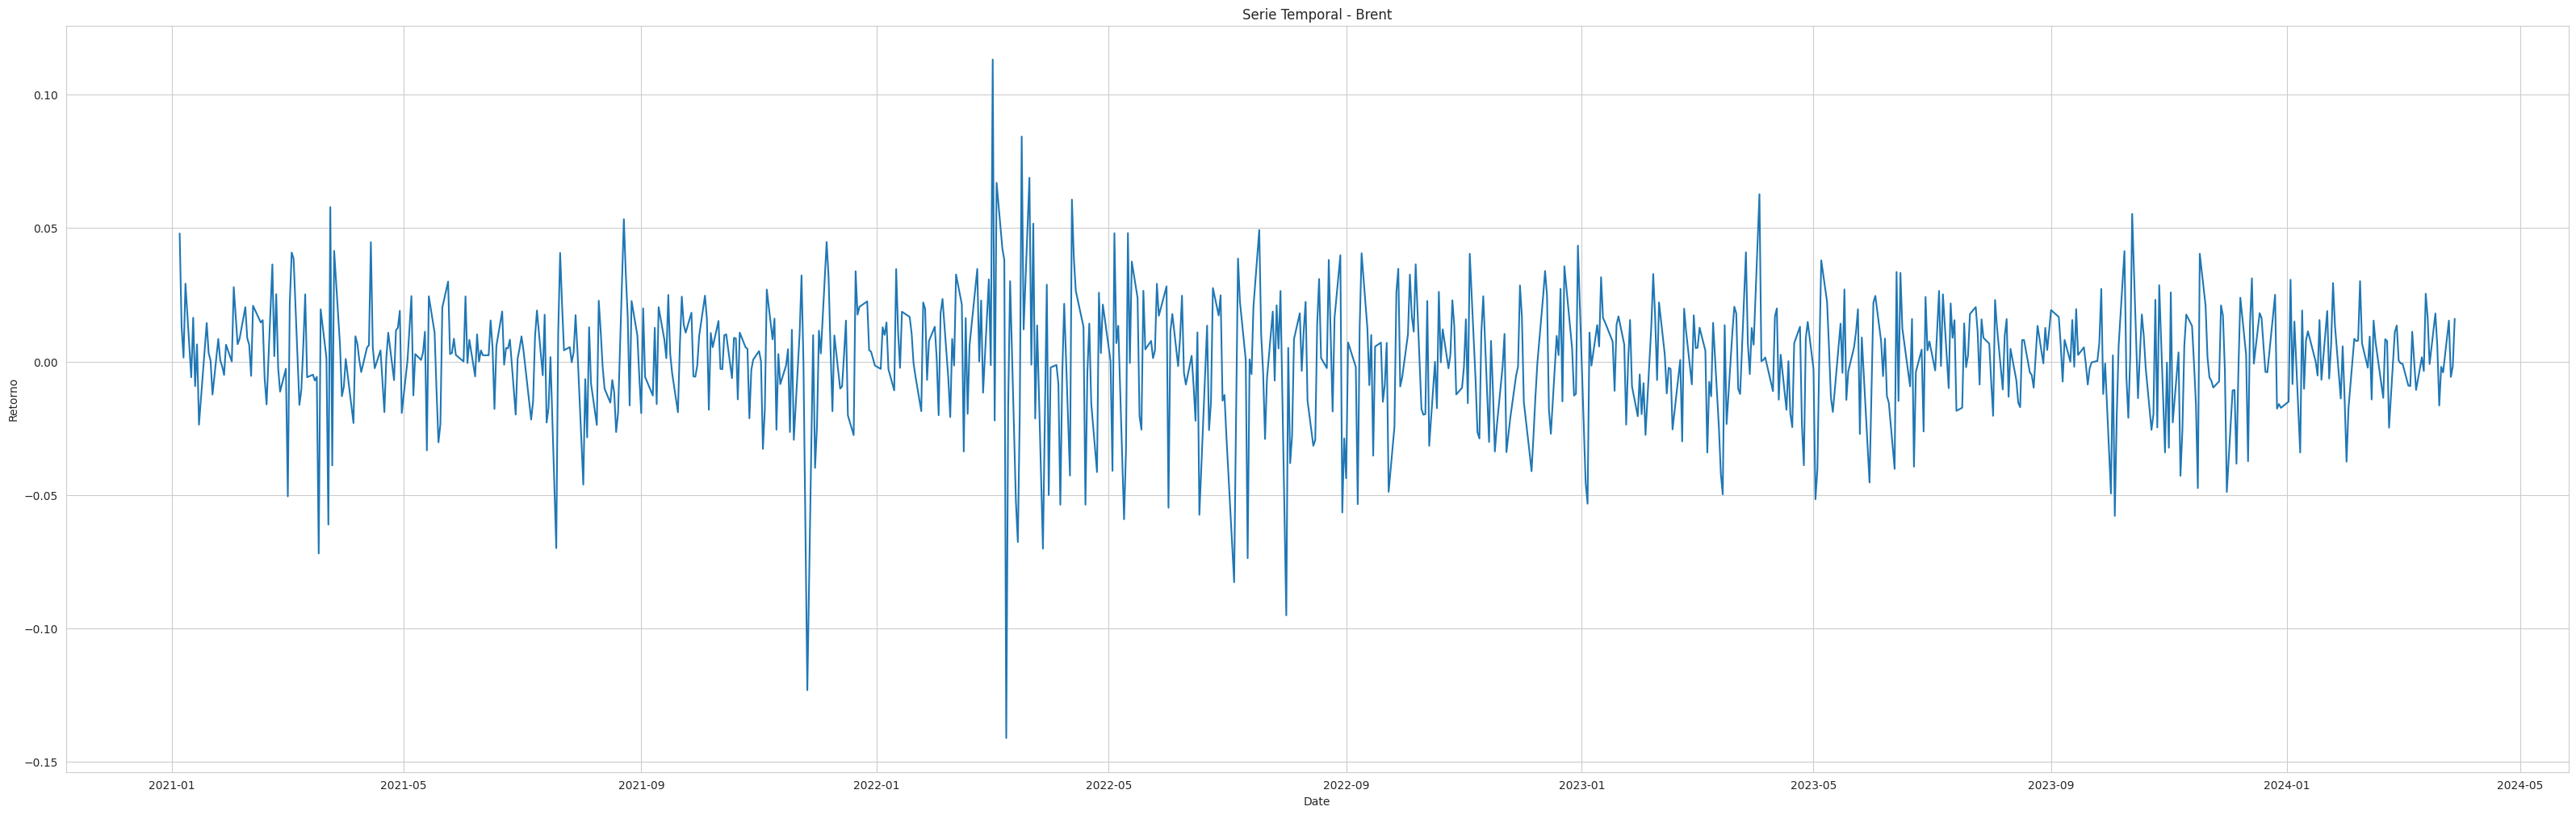

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Retorno', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

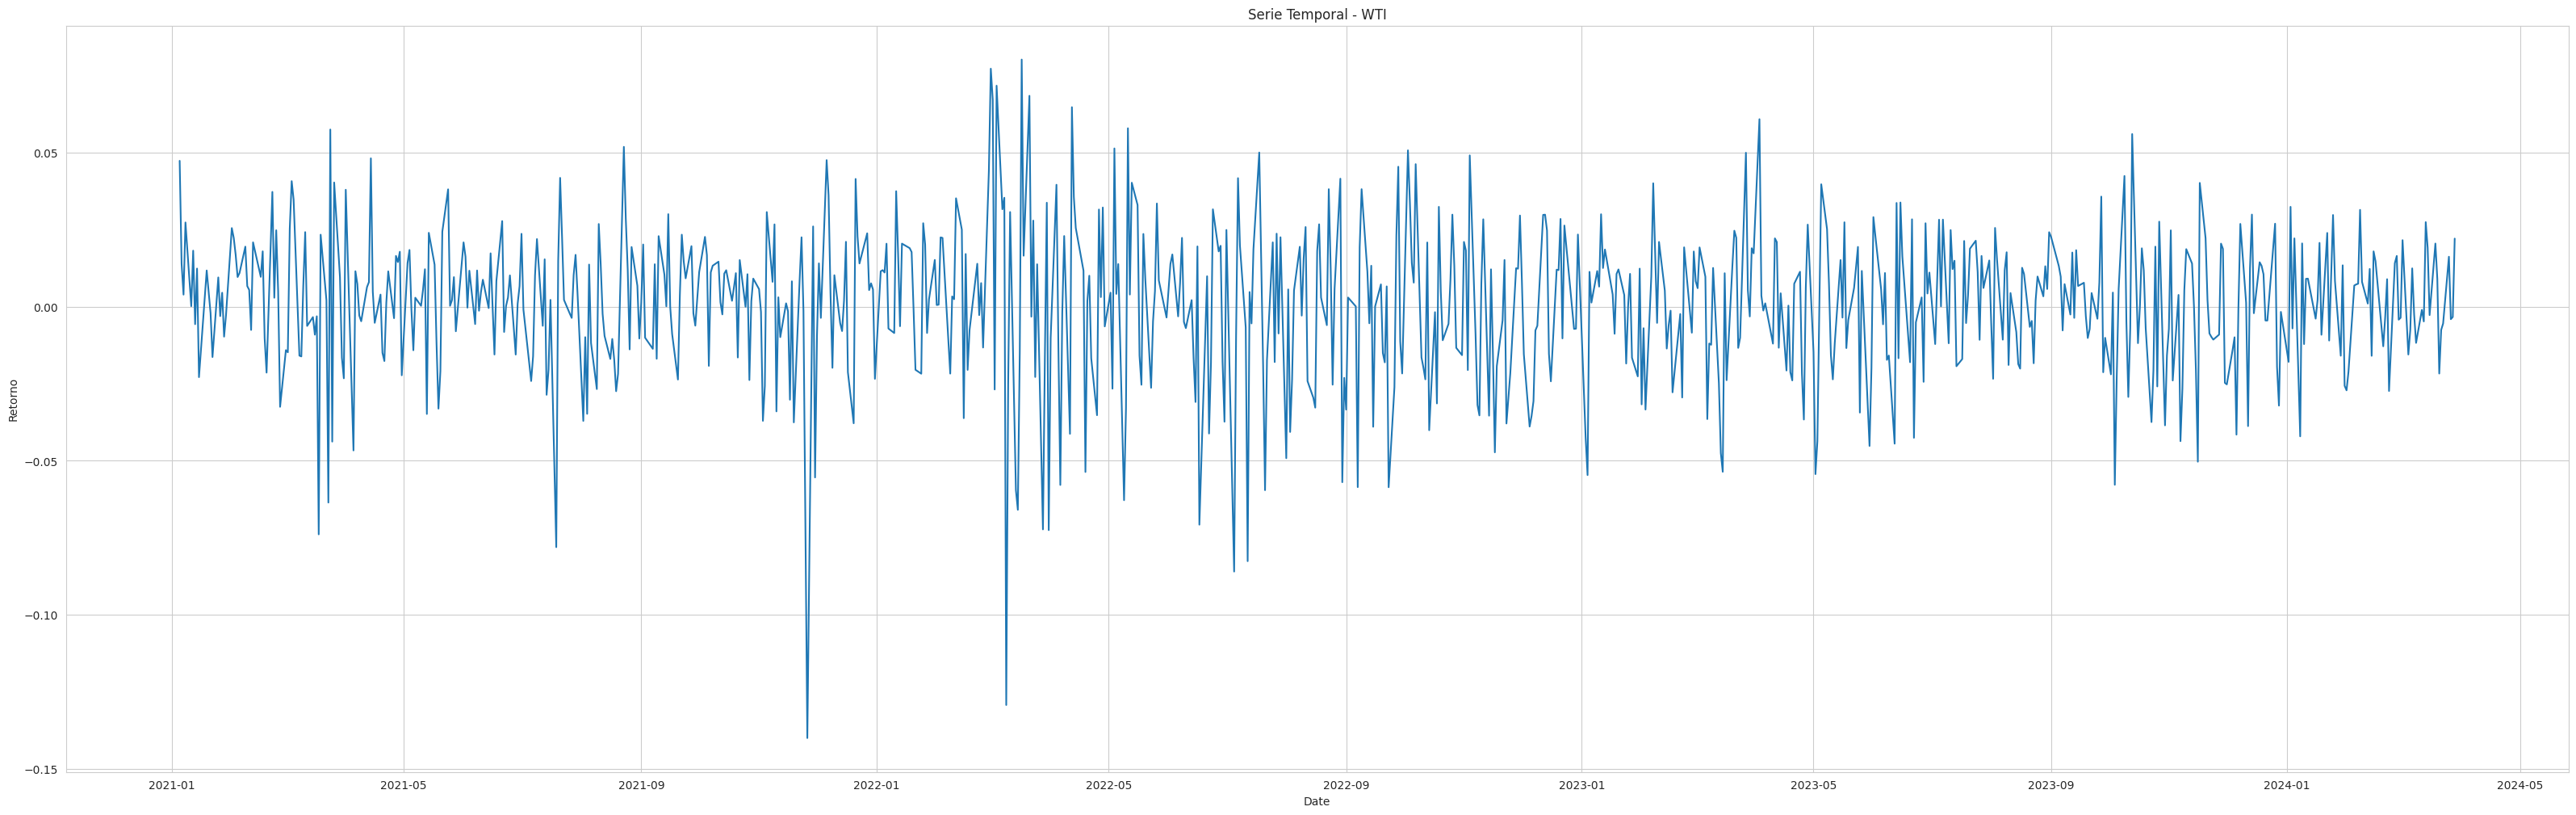

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Retorno', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

Verificando análise gráfica é possível notar que as series de retorno aparentam ser estacionárias, porém para que seja possível confirmar isso será realizado o teste de AD FUller, que testa as seguintes hipóteses:

Hipótese nula: a série possui raiz unitária**, ou seja, não estacionária.

Hipótese alternativa: série estacionária

Será adotado um nível de 5% para significância na análise.

** Uma série temporal com uma raiz unitária é como uma série que está "presa" a uma tendência, e não está "livre" para variar ou flutuar naturalmente. Isso significa que, mesmo que haja algumas variações de curto prazo, a série ainda está sendo puxada ou influenciada por algo constante ou de longo prazo.

Como resultado do teste será obtido o Pvalor, que caso seja maior que 5% indica que é viável acatar a hipótese nula de que a serie não é estacionária. Já caso seja menor que 5% deve-se acatar a hipotese alternativa de que a serie é estacionária.

## Testes de Estacionaridade e AutoCorrelação

### PETR4

In [30]:
Pvalor_Petr4 = adfuller(petr4['Retorno'].dropna())[1]

if Pvalor_Petr4 <= 0.05:
    print('Deve-se rejeitar H0 (Estacionária)')
else:
    print('Deve-se acatar H0 (Não estacionária)')


Deve-se rejeitar H0 (Estacionária)


In [31]:
lb_test = sm.stats.acorr_ljungbox(petr4['Retorno'].dropna(), lags=20)

In [32]:
lb_test['lb_pvalue'].apply( lambda x: x < 0.05)

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19    False
20    False
Name: lb_pvalue, dtype: bool

Através dos testes foi possível confirmar que a serie de retornos não possui tendências, e apenas lags específicos de autocorrelação (12 até 17), além disso possui picos elevados de variância ao longo do tempo como é possível observar no gráfico da serie. Por esses motivos será utilizado o modelo GARCH pois além de ser mais robusto para modelagem de series temporais financeiras, é muito bom para capturar a volatilidade condicional dos dados, ou seja, volatilidade que varia ao longo do tempo e é influenciada por condições e eventos passados.

### Prio3

In [33]:
Pvalor_Prio3 = adfuller(prio3['Retorno'].dropna())[1]

if Pvalor_Prio3 <= 0.05:
    print('Deve-se rejeitar H0 (Estacionária)')
else:
    print('Deve-se acatar H0 (Não estacionária)')


Deve-se rejeitar H0 (Estacionária)


In [34]:
lb_test = sm.stats.acorr_ljungbox(prio3['Retorno'].dropna(), lags=20)

In [35]:
lb_test['lb_pvalue'].apply( lambda x: x < 0.05)

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13     True
14     True
15     True
16    False
17    False
18    False
19    False
20    False
Name: lb_pvalue, dtype: bool

Através dos testes foi possível confirmar que a serie de retornos não possui tendências, e apenas lags específicos de autocorrelação (12 até 15), além disso possui picos elevados de variância ao longo do tempo como é possível observar no gráfico da serie. Por esses motivos será utilizado o modelo GARCH pois além de ser mais robusto para modelagem de series temporais financeiras, é muito bom para capturar a volatilidade condicional dos dados, ou seja, volatilidade que varia ao longo do tempo e é influenciada por condições e eventos passados.

### Brent

In [36]:
Pvalor_Brent = adfuller(Brent['Retorno'].dropna())[1]

if Pvalor_Brent <= 0.05:
    print('Deve-se rejeitar H0 (Estacionária)')
else:
    print('Deve-se acatar H0 (Não estacionária)')


Deve-se rejeitar H0 (Estacionária)


In [37]:
lb_test = sm.stats.acorr_ljungbox(Brent['Retorno'].dropna(), lags=20)

In [38]:
lb_test['lb_pvalue'].apply( lambda x: x < 0.05)

1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
Name: lb_pvalue, dtype: bool

Fiquei em dúvida aqui, pois um teste aponta para uma serie estacionária, porém no teste de autocorrelação é possível notar que vários dias apresentam autocorrelação o que é um indicativo para uma serie não estacionária.

### WTI

In [39]:
Pvalor_WTI = adfuller(WTI['Retorno'].dropna())[1]

if Pvalor_WTI <= 0.05:
    print('Deve-se rejeitar H0 (Estacionária)')
else:
    print('Deve-se acatar H0 (Não estacionária)')


Deve-se rejeitar H0 (Estacionária)


In [40]:
lb_test = sm.stats.acorr_ljungbox(WTI['Retorno'].dropna(), lags=20)

In [41]:
lb_test['lb_pvalue'].apply( lambda x: x < 0.05)

1     False
2     False
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
Name: lb_pvalue, dtype: bool

Mesma dúvida anterior

## Modelagem

### Petr4

In [42]:
model_petr4 = arch_model(petr4['Retorno'].dropna(), p=1, q=1, vol='GARCH')
model_petr4 = model_petr4.fit(disp='off')

In [43]:
model_petr4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Retorno   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1702.80
Distribution:                  Normal   AIC:                          -3397.60
Method:            Maximum Likelihood   BIC:                          -3378.91
                                        No. Observations:                  791
Date:                Wed, May 29 2024   Df Residuals:                      790
Time:                        23:42:55   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.4165e-03  9.540e-04      1.485      0.138 [-4.533e-04,3.286e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.2832e-05  2.942e-11  4.362e+05      0.000 [1.283e-05,1.283e-05]
alpha[1]       0.0375  1.522e-02      2.464  1.374e-02 [7.673e-03,6.733e-02]
beta[1]        0.9475  1.308e-02     72.414      0.000     [  0.922,  0.973]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date', ylabel='Retorno'>

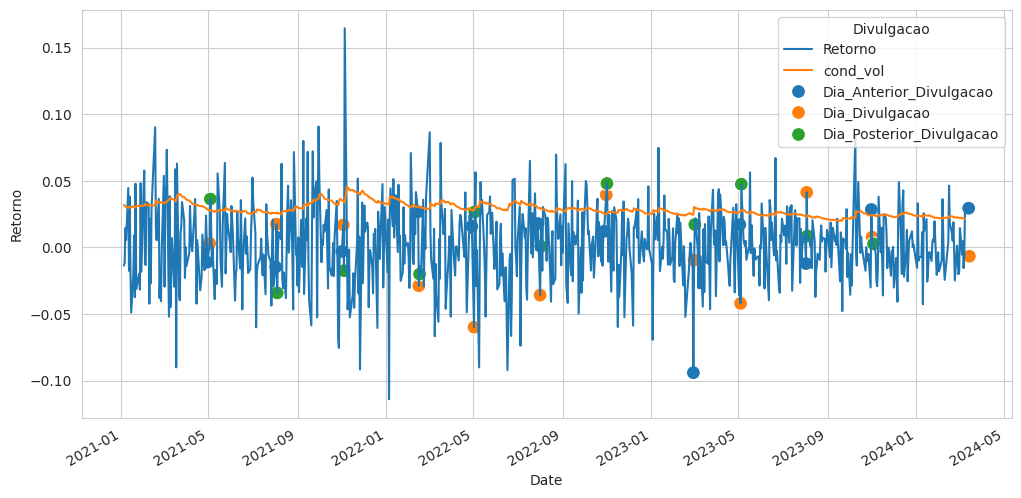

In [44]:
plt.figure(figsize=(12,6))
petr4['Retorno'].plot()
model_petr4.conditional_volatility.plot()
sns.scatterplot(x=divulgacoes_petr4.index, y='Retorno', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)

Ao verificar a volatilidade prevista pelo modelo com as demais informações da serie (retorno e dias de divulgação) é possível notar que os dias relacionados a divulgação de balanço tem uma relação com a volatilidade, já que os clustes de volatilidade se encontram com a marcação dos dias.

### Prio3

In [45]:
model_prio3 = arch_model(prio3['Retorno'].dropna(), p=1, q=1, vol='GARCH')
model_prio3 = model_prio3.fit(disp='off')

In [46]:
model_prio3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Retorno   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1713.69
Distribution:                  Normal   AIC:                          -3419.38
Method:            Maximum Likelihood   BIC:                          -3400.66
                                        No. Observations:                  795
Date:                Wed, May 29 2024   Df Residuals:                      794
Time:                        23:42:56   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.4670e-03  9.612e-04      1.526      0.127 [-4.169e-04,3.351e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.2906e-12  1.507e-13     55.012      0.000 [7.995e-12,8.586e-12]
alpha[1]       0.0103  7.559e-04     13.589  4.630e-42 [8.791e-03,1.175e-02]
beta[1]        0.9886  1.048e-03    942.962      0.000     [  0.987,  0.991]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date', ylabel='Retorno'>

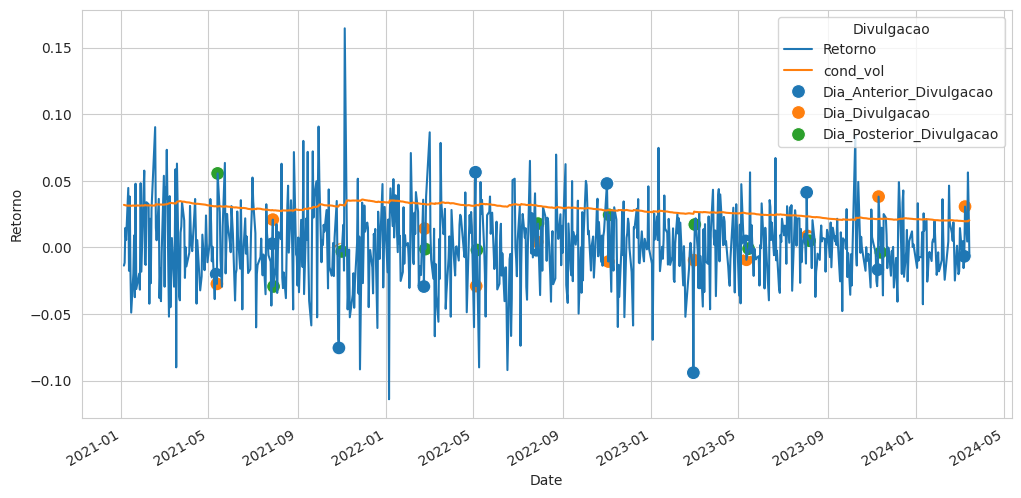

In [47]:
plt.figure(figsize=(12,6))
prio3['Retorno'].plot()
model_prio3.conditional_volatility.plot()
sns.scatterplot(x=divulgacoes_prio3.index, y='Retorno', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)

Não foi possível observar uma volatilidade significativa nos dias próximos a divulgação de balanço. O que pode indicar que esse tipo de fenômeno é mais propricio de ocorrer em ações blue chip, o que faz sentido já que são ações com um volume maior de movimentação nos pregões.

### Brent

In [48]:
model_brent = arch_model(Brent['Retorno'].dropna(), p=1, q=1, vol='GARCH')
model_brent = model_brent.fit(disp='off')

In [49]:
model_brent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Retorno   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1949.22
Distribution:                  Normal   AIC:                          -3890.44
Method:            Maximum Likelihood   BIC:                          -3871.64
                                        No. Observations:                  813
Date:                Wed, May 29 2024   Df Residuals:                      812
Time:                        23:42:57   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1241e-03  7.541e-04      1.491      0.136 [-3.538e-04,2.602e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0785e-05  1.522e-11  7.084e+05      0.000 [1.078e-05,1.078e-05]
alpha[1]       0.1000  2.647e-02      3.778  1.584e-04   [4.812e-02,  0.152]
beta[1]        0.8800  2.155e-02     40.827      0.000     [  0.838,  0.922]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date'>

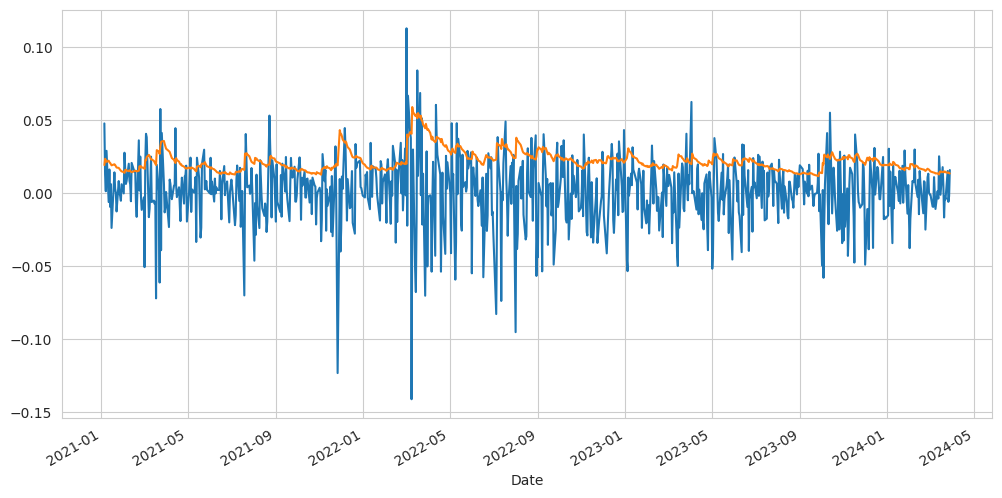

In [50]:
plt.figure(figsize=(12,6))
Brent['Retorno'].plot()
model_brent.conditional_volatility.plot()
#sns.scatterplot(x=divulgacoes_prio3.index, y='Retorno', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)

<Axes: xlabel='Date'>

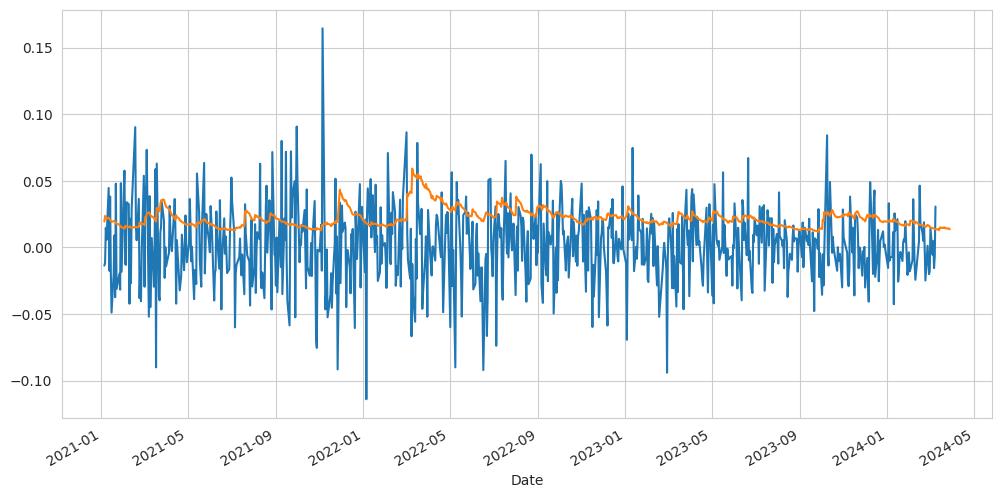

In [55]:
plt.figure(figsize=(12,6))
petr4['Retorno'].plot()
model_brent.conditional_volatility.plot()


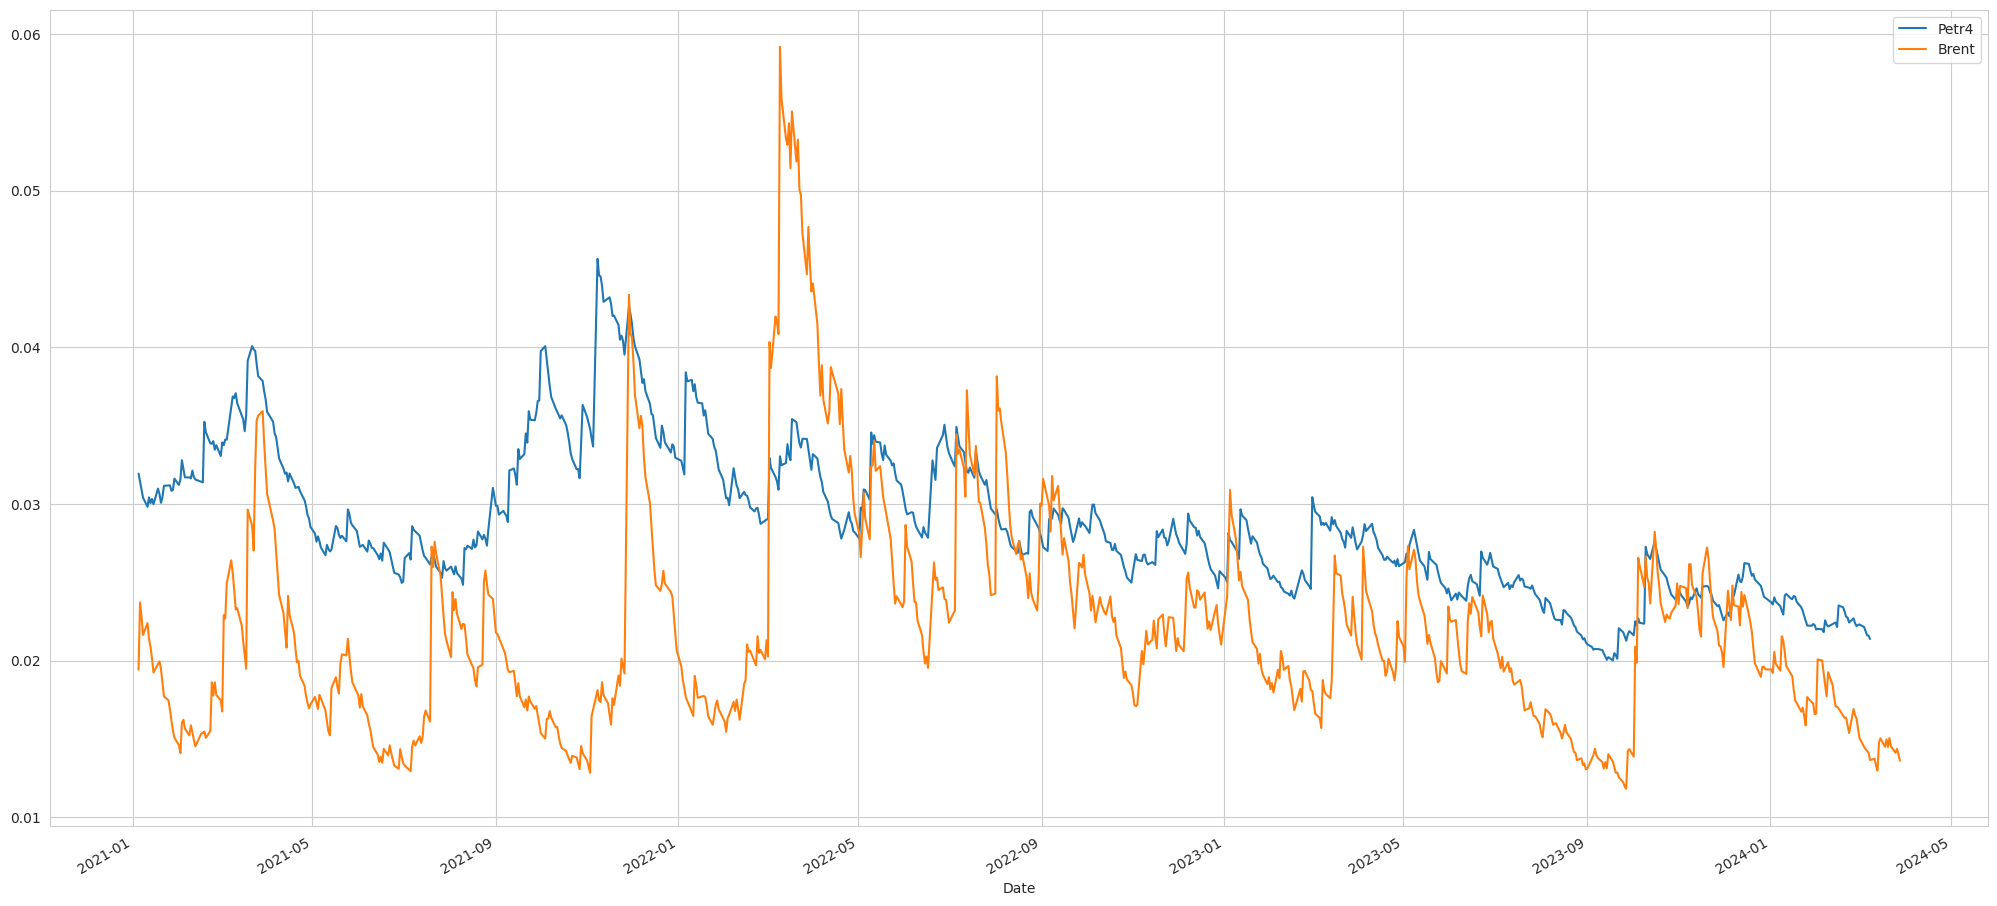

In [67]:
plt.figure(figsize=(25,12))
model_petr4.conditional_volatility.plot(label='Petr4')
model_brent.conditional_volatility.plot(label='Brent')
plt.legend()

É possível notar que a volatilidade do Brent tem uma relação com a volatilidade da Petr4. Existem varios momentos das series que a volatilidade da Petr4 está caindo e uma volatilidade alta no Brent gera um movimento no papel da petrobrás. Isso corrobora com a afirmação que o preço da commoditie impacta no preço da ação da empresa do setor, já que se trata de uma matéria prima para a petrobrás e o aumento no preço significa aumento de custo. Essa análise fortalece a ideia de que a ruídos internos tem impacto sobre o preço das ações da Petr4, e ajuda entender que sim, a divulgação de balanços tem um impacto direto na volatilidade dos preços das ações de blue ships, pois também é um ruído interno.

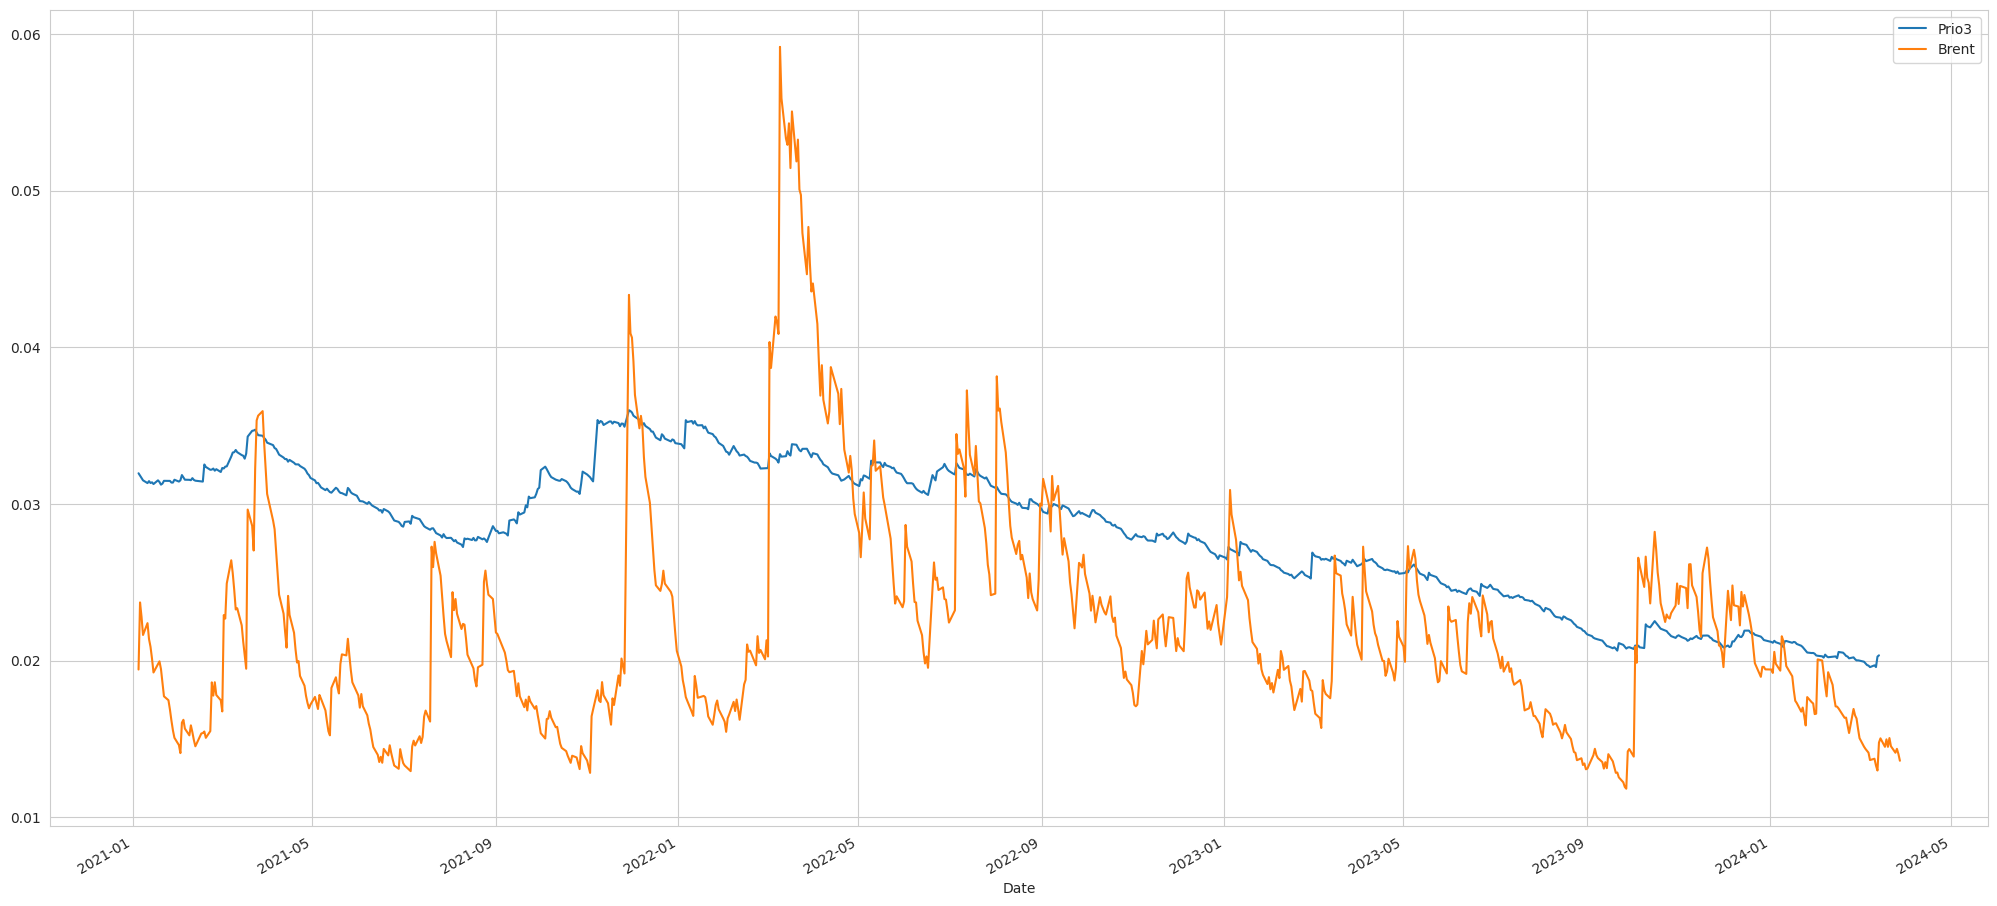

In [68]:
plt.figure(figsize=(25,12))
model_prio3.conditional_volatility.plot(label='Prio3')
model_brent.conditional_volatility.plot(label='Brent')
plt.legend()

Já em relação a Petrorio é possível ver que as series temporais não tem uma relação direta, o que reforça a ideia de esses ruídos internos podem estar mais relacionados com a Blue Ships e não as smallcaps.  

### WTI

In [51]:
model_WTI = arch_model(WTI['Retorno'].dropna(), p=1, q=1, vol='GARCH')
model_WTI = model_WTI.fit(disp='off')

In [52]:
model_WTI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Retorno   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1900.84
Distribution:                  Normal   AIC:                          -3793.68
Method:            Maximum Likelihood   BIC:                          -3774.88
                                        No. Observations:                  814
Date:                Wed, May 29 2024   Df Residuals:                      813
Time:                        23:42:59   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.2266e-03  7.636e-04      1.606      0.108 [-2.700e-04,2.723e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.0190e-05  1.515e-05      3.973  7.096e-05 [3.050e-05,8.988e-05]
alpha[1]       0.1000  2.187e-02      4.574  4.792e-06   [5.715e-02,  0.143]
beta[1]        0.8000  2.414e-02     33.138 8.351e-241     [  0.753,  0.847]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date'>

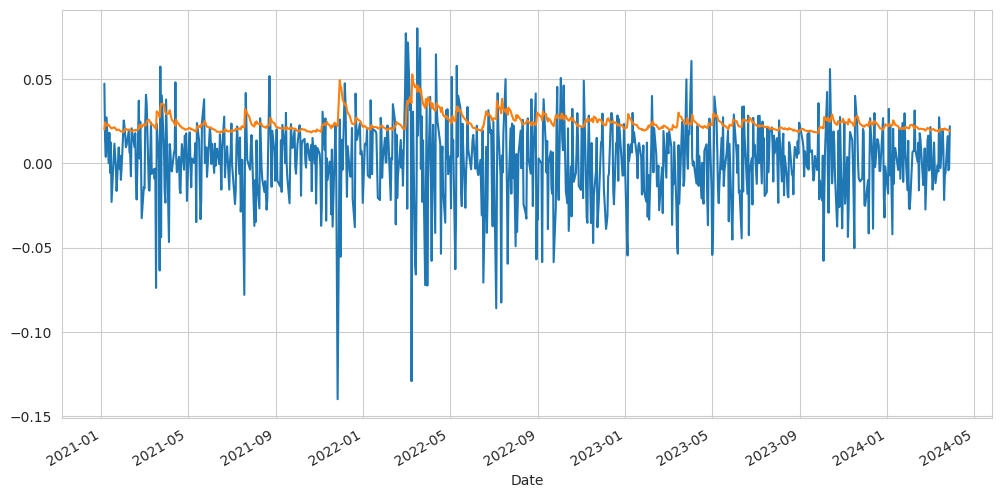

In [53]:
plt.figure(figsize=(12,6))
WTI['Retorno'].plot()
model_WTI.conditional_volatility.plot()
#sns.scatterplot(x=divulgacoes_prio3.index, y='Retorno', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)

Mesma análise anterior.